### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns

from textwrap import wrap

### Ground truth

In [4]:
official_names = ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride']
protons = [4, 4, 5, 5, 13]
molar_proportions = [0.3022, 0.2240, 0.1253, 0.2028, 0.1457]

In [5]:
real_visible_proportions = [prop*prot for prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [p/sum(real_visible_proportions) for p in real_visible_proportions]
real_visible_proportions

[0.2143490442245629,
 0.1588821505833954,
 0.11109337872823348,
 0.1798063623789765,
 0.3358690640848317]

### Loading the data

In [6]:
components = np.loadtxt('metabolity.csv', delimiter=',', skiprows=1)
ppm_components = components[:,0]
components = components[:,1:]

mix = np.loadtxt('metabolity_shimy.csv', delimiter=',', skiprows=1)
ppm = mix[:,0]
mix = mix[:,1]

In [7]:
# ppm = #np.array with shape (number_of_points on frequency axis for mixture,)
# mix = #np.array with shape (number_of_points on frequency axis,)
# ppm_comp = #np.array with shape (number_of_points on frequency axis for components, )
# components = #np.array with shape (number_of_points on frequency axis for components, number of components)
# real_visible_proportions = #np.array with shape (number of components,)

In [8]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [9]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [10]:
mix = Spectrum(confs=list(zip(ppm,mix)))

In [11]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [12]:
# mix.plot(profile=True)
# comp0.plot(profile=True)
# comp1.plot(profile=True) 
# comp2.plot(profile=True)
# comp3.plot(profile=True)
# comp4.plot(profile=True)

### Additional preprocessing: removing peak from solvent

In [13]:
def remove_peak_from_region(spectrum, region):
    
    lower_bound = region[0]
    upper_bound = region[1]
    
    new_confs = np.array(spectrum.confs)
    in_region = np.logical_and(lower_bound < new_confs[:,0], new_confs[:,0] < upper_bound)
    new_confs[in_region, 1] = 0
    
    return Spectrum(confs=list(zip(new_confs[:,0], new_confs[:,1])))

In [14]:
preprocessed_spectra = []
for sp in [mix] + spectra:
    no_solvent_peak = remove_peak_from_region(sp, (4.4, 4.8))
    no_solvent_peak.normalize()
    preprocessed_spectra.append(no_solvent_peak)
mix = preprocessed_spectra[0]
spectra = preprocessed_spectra[1:]
del(preprocessed_spectra)

### Alignment

In [15]:
def shift_one_spectrum(sp, how_much):
    res = sp
    old_confs = np.array(sp.confs)

    new_ppm_non_unique = old_confs[:,0] + how_much
    resampled = sp.resample(np.unique(new_ppm_non_unique) + how_much)
    new_ppm_unique = np.array(resampled.confs)[:,0]
    new_ints = np.array(resampled.confs)[:,1]
    res = Spectrum(confs=list(zip(new_ppm_unique + how_much, new_ints)))
    return(res)

In [16]:
#shift_right = [0.14, 0.15, 0.14, 0.14, 0.14] #equivalently, we can shift mixture 0.14 to the left
#mix = shift_one_spectrum(mix, -0.14)

### Preprocessing

In [17]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [18]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [19]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [20]:
spectra_and_mixture = spectra + [mix]

In [21]:
spectra_and_mixture = shift(spectra_and_mixture)

In [22]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [23]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [24]:
cma = common_mass_axis(spectra_and_mixture)

In [25]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [26]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [27]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [28]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [29]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [30]:
# mix.plot(profile=True)
# comp0.plot(profile=True)
# comp1.plot(profile=True) 
# comp2.plot(profile=True)
# comp3.plot(profile=True)
# comp4.plot(profile=True)

### Removing unnecessary data points

In [31]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.Spectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [32]:
#2.8, 6.1
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 2.8, 6.1)

In [33]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [34]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [35]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [36]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [37]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [38]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [39]:
labels = ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride', 'Mixture']
for i, sp in enumerate(spectra_and_mixture):
    sp.label = labels[i]

<IPython.core.display.Javascript object>


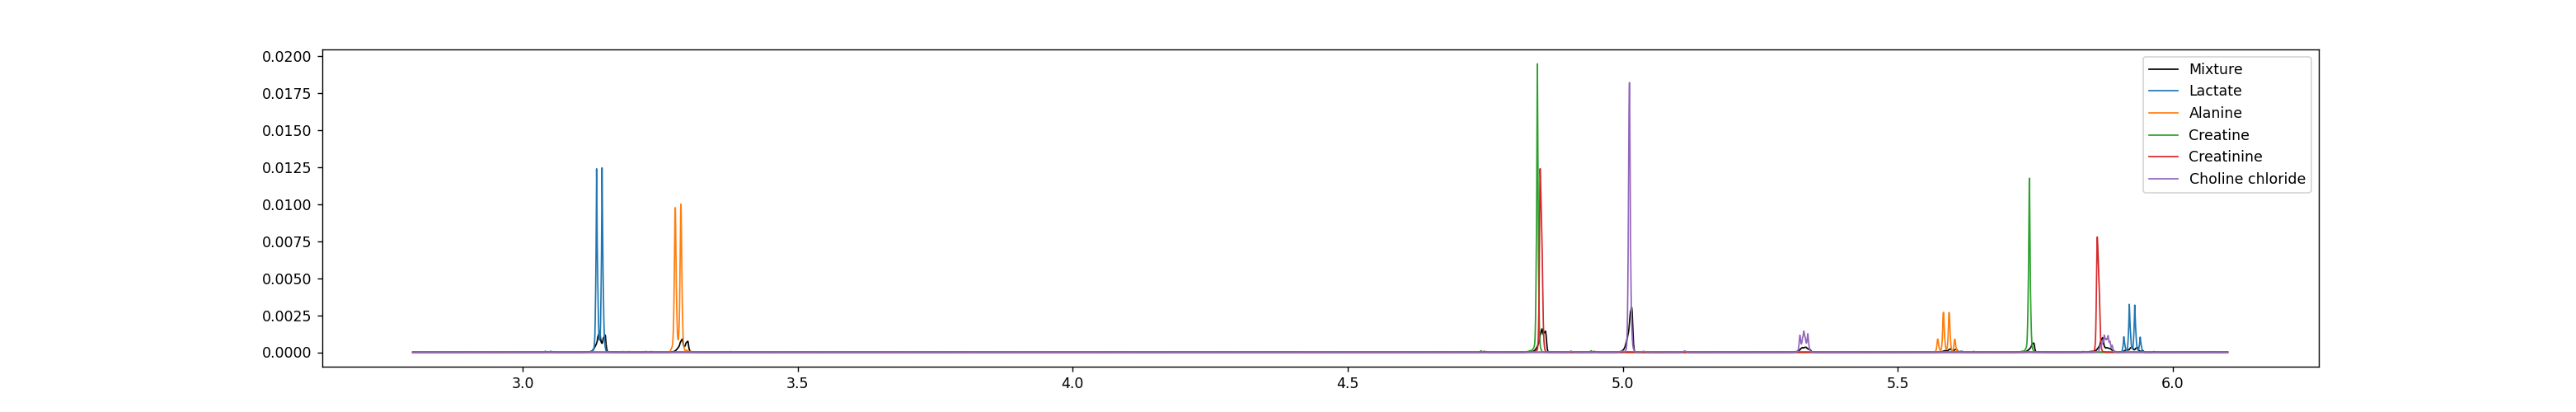

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True)
comp4.plot(profile=True)
ax.legend()
#plt.savefig('aligned_spectra.png', dpi=300)

### Finding optimal values of parameters

In [41]:
import time
import pandas as pd
import pulp

In [42]:
lower_limit = 0.01
upper_limit = 0.31
step = 0.01

In [43]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3, comp4], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59747.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1467257.33it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.27s/it]


Estimation for 0.01 and 0.01 done
It took: 23.406173944473267 seconds.
[0.22046182856900015, 0.10259832063900007, 0.06581448343700004, 0.16425592775100012, 0.3227830424860002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1806147.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.60s/it]


Estimation for 0.01 and 0.02 done
It took: 18.674657583236694 seconds.
[0.22425526812600013, 0.08707364012000006, 0.06860563268000004, 0.1570739486010001, 0.3264037318330002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94893.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2402298.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.88s/it]


Estimation for 0.01 and 0.03 done
It took: 16.956629991531372 seconds.
[0.22378876126500014, 0.08599632301500006, 0.06560739175800004, 0.15732205972900012, 0.3257794101100002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2256833.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.13s/it]


Estimation for 0.01 and 0.04 done
It took: 20.206804275512695 seconds.
[0.22340356823900015, 0.08482710180700005, 0.06359170776300004, 0.1573733391600001, 0.32501066070000023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 136178.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2018471.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.21s/it]


Estimation for 0.01 and 0.05 done
It took: 15.302174806594849 seconds.
[0.22288083888900015, 0.08357849023400006, 0.061427088772000045, 0.15758019536500012, 0.3242794421280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2741333.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.90s/it]


Estimation for 0.01 and 0.060000000000000005 done
It took: 15.967336893081665 seconds.
[0.22240815083200013, 0.08294333669200006, 0.05972398344300004, 0.15734572403300012, 0.32346802433600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 165130.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2781540.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.96s/it]


Estimation for 0.01 and 0.06999999999999999 done
It took: 16.024593353271484 seconds.
[0.22213762190300013, 0.08157835110900005, 0.05787940139800004, 0.1572692509990001, 0.3228781923350002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137970.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2647693.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.67s/it]


Estimation for 0.01 and 0.08 done
It took: 19.74241352081299 seconds.
[0.22157220673100014, 0.08014368837600006, 0.056792944913000035, 0.15741186232900012, 0.3219250939490002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 50051.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2133924.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.09s/it]


Estimation for 0.01 and 0.09 done
It took: 18.179928064346313 seconds.
[0.22134497863800015, 0.07942215735500005, 0.05516109259900003, 0.15748922576800012, 0.32100018055700025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2750677.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.43s/it]


Estimation for 0.01 and 0.09999999999999999 done
It took: 15.499067544937134 seconds.
[0.22009582189100013, 0.07778742085300006, 0.05395890705500003, 0.15741556131000012, 0.32012243842400023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2569315.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.51s/it]


Estimation for 0.01 and 0.11 done
It took: 15.578397035598755 seconds.
[0.21909347559100015, 0.07694522687500005, 0.05245554768100003, 0.1572216541780001, 0.3191382598130002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79437.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2393908.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.96s/it]


Estimation for 0.01 and 0.12 done
It took: 29.033071279525757 seconds.
[0.21848942473200014, 0.07608476625700006, 0.05225558726800004, 0.15728467657000011, 0.31813245676000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54189.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1315611.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.02s/it]


Estimation for 0.01 and 0.13 done
It took: 22.164162158966064 seconds.
[0.21693371647100013, 0.07520196177200006, 0.05076821838900004, 0.1568183588530001, 0.3174928250390002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2387329.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.65s/it]


Estimation for 0.01 and 0.14 done
It took: 17.74055814743042 seconds.
[0.21646295042500013, 0.07429209648000006, 0.04974443176800004, 0.15698173518200012, 0.3171056431930002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 20460.02it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1390872.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.55s/it]


Estimation for 0.01 and 0.15000000000000002 done
It took: 18.64948797225952 seconds.
[0.21499563875200015, 0.07338211768500005, 0.049639361867000034, 0.15611103870900012, 0.31653941900100024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 28416.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1443854.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.30s/it]


Estimation for 0.01 and 0.16 done
It took: 21.411099910736084 seconds.
[0.21336158286400014, 0.07246140495400004, 0.04827753113400003, 0.1560130360540001, 0.3163247543180002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 50291.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1724493.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.09s/it]


Estimation for 0.01 and 0.17 done
It took: 24.22807002067566 seconds.
[0.21294562131600014, 0.07199803868900004, 0.047690986386000035, 0.1560293100530001, 0.3163536951050002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 128659.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2163379.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.32s/it]


Estimation for 0.01 and 0.18000000000000002 done
It took: 17.4019615650177 seconds.
[0.21102833034100013, 0.07140078517900005, 0.04718551968000004, 0.1552857427260001, 0.3164278133920002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77101.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2068934.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.22s/it]


Estimation for 0.01 and 0.19 done
It took: 23.30306053161621 seconds.
[0.21043170909200015, 0.07067455981600004, 0.04680637703900003, 0.1548200692890001, 0.3164886490260002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40485.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1578668.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.48s/it]


Estimation for 0.01 and 0.2 done
It took: 18.62539315223694 seconds.
[0.20934202074300015, 0.06981458878500005, 0.04544934799800003, 0.1544439996650001, 0.3165533933930002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66156.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1353096.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.62s/it]


Estimation for 0.01 and 0.21000000000000002 done
It took: 22.716434955596924 seconds.
[0.20761803199300014, 0.06979579402100004, 0.04519460381100003, 0.1544607153650001, 0.31662176220600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 35128.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1591007.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.38s/it]


Estimation for 0.01 and 0.22 done
It took: 16.52323269844055 seconds.
[0.20655151927900015, 0.06898846131600005, 0.04461126224400003, 0.1534735915170001, 0.3166878086960002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2122738.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.39s/it]


Estimation for 0.01 and 0.23 done
It took: 14.45132064819336 seconds.
[0.20454169228700014, 0.06853776027500004, 0.04419392442200003, 0.1534942835450001, 0.3167885878890002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87746.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2982628.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.61s/it]


Estimation for 0.01 and 0.24000000000000002 done
It took: 16.677449703216553 seconds.
[0.20414967843700013, 0.06819760286300004, 0.044131729312000025, 0.1535100481210001, 0.31683518454300025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2107952.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.08s/it]


Estimation for 0.01 and 0.25 done
It took: 18.165366172790527 seconds.
[0.20213686618300014, 0.06764327834400004, 0.04318096045800003, 0.15258913897400012, 0.3169382573770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92385.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2097964.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.25s/it]


Estimation for 0.01 and 0.26 done
It took: 15.332913637161255 seconds.
[0.20079913453500015, 0.06744826046400004, 0.04274605900700003, 0.1524154826450001, 0.31701893133800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106454.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2713873.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.44s/it]


Estimation for 0.01 and 0.27 done
It took: 14.505263805389404 seconds.
[0.19969738236400014, 0.06744352845900004, 0.04236272131800003, 0.15155682862700012, 0.31707001875500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81920.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2905998.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.40s/it]


Estimation for 0.01 and 0.28 done
It took: 15.464882373809814 seconds.
[0.19744089797900014, 0.06735445124000004, 0.04234652488000003, 0.15158268490900012, 0.3171424345460002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1782214.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.54s/it]


Estimation for 0.01 and 0.29000000000000004 done
It took: 20.64214777946472 seconds.
[0.19688691321700014, 0.06733902894900004, 0.04156187397300003, 0.1511430472060001, 0.31722789084800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72565.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1810630.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.16s/it]


Estimation for 0.01 and 0.3 done
It took: 15.249368667602539 seconds.
[0.19511371249100015, 0.06729128759400003, 0.04096703933700003, 0.1511571100820001, 0.3173052983280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2880325.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.55s/it]


Estimation for 0.02 and 0.01 done
It took: 14.614359140396118 seconds.
[0.21844639678300015, 0.17572648702300012, 0.11264763478400007, 0.1715505663610001, 0.3152135959200002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2847315.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.30s/it]


Estimation for 0.02 and 0.02 done
It took: 14.356125354766846 seconds.
[0.22759885645400013, 0.14542711999500008, 0.11749948673400008, 0.17007819617200012, 0.32684098834000025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2741003.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.00s/it]


Estimation for 0.02 and 0.03 done
It took: 20.068106412887573 seconds.
[0.22927611031500017, 0.1380090549290001, 0.11804945301500008, 0.1635771650050001, 0.32827535223400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2000796.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.78s/it]


Estimation for 0.02 and 0.04 done
It took: 15.870096921920776 seconds.
[0.22961079371500018, 0.1371367062770001, 0.11787248028400009, 0.1642288248360001, 0.32683207347600024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2796786.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.56s/it]


Estimation for 0.02 and 0.05 done
It took: 14.621481657028198 seconds.
[0.22975145691900017, 0.1363350464070001, 0.11785248175800009, 0.16455060042200012, 0.32607490410500023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88487.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2566475.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.74s/it]


Estimation for 0.02 and 0.060000000000000005 done
It took: 17.81477403640747 seconds.
[0.22983815065600016, 0.13574135375500007, 0.11789266530600008, 0.16485606626300012, 0.32537922829400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1439252.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.65s/it]


Estimation for 0.02 and 0.06999999999999999 done
It took: 29.7819881439209 seconds.
[0.22979504806400017, 0.1351403383760001, 0.11802069108000009, 0.1653427208920001, 0.3246773517660002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45294.86it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1442938.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.72s/it]


Estimation for 0.02 and 0.08 done
It took: 27.85450053215027 seconds.
[0.22962253106000016, 0.1345769894090001, 0.11815463162700009, 0.16582006567400012, 0.32395781726900025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59409.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2176205.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.76s/it]


Estimation for 0.02 and 0.09 done
It took: 16.85245132446289 seconds.
[0.22966141519500016, 0.13369013381500008, 0.11824580015400009, 0.16613698796500012, 0.3231796378400002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2268893.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.75s/it]


Estimation for 0.02 and 0.09999999999999999 done
It took: 16.827897310256958 seconds.
[0.22974983020000017, 0.1328073066880001, 0.11832684686900008, 0.1664275686310001, 0.32251746487400024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2430832.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.93s/it]


Estimation for 0.02 and 0.11 done
It took: 17.02154850959778 seconds.
[0.22981655630400016, 0.13188165724700007, 0.11840990902700008, 0.1665337427590001, 0.32183837047000025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105384.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2363330.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.67s/it]


Estimation for 0.02 and 0.12 done
It took: 16.760855674743652 seconds.
[0.22987603446400018, 0.1309831060580001, 0.11852161871400008, 0.1668476775990001, 0.32085551294600023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2392147.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.17s/it]


Estimation for 0.02 and 0.13 done
It took: 33.254770040512085 seconds.
[0.22985558322000016, 0.13001317466700008, 0.11863060998700008, 0.1672722945480001, 0.31996890109300025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26749.39it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1509355.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.99s/it]


Estimation for 0.02 and 0.14 done
It took: 21.12731957435608 seconds.
[0.22973282602000017, 0.1290944009190001, 0.11873705736400009, 0.16760308677700012, 0.3190721095780002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2347823.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.97s/it]


Estimation for 0.02 and 0.15000000000000002 done
It took: 18.04876136779785 seconds.
[0.22967377530500016, 0.12828276708900008, 0.11882579935700008, 0.16783568547700012, 0.31824432851000023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40960.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2276246.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.93s/it]


Estimation for 0.02 and 0.16 done
It took: 18.033310413360596 seconds.
[0.22956495841600016, 0.12738013368200007, 0.11888578112200009, 0.16801086856200012, 0.3176698477290002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74367.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1895285.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.51s/it]


Estimation for 0.02 and 0.17 done
It took: 20.6021888256073 seconds.
[0.22925458957300016, 0.1269539703910001, 0.11894031735800008, 0.16816139825000012, 0.3171647309340002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26579.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1591808.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.28s/it]


Estimation for 0.02 and 0.18000000000000002 done
It took: 20.383304357528687 seconds.
[0.22910277576300014, 0.12648131528300008, 0.11895203607300009, 0.16829633751000012, 0.3172080760840002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2720881.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.41s/it]


Estimation for 0.02 and 0.19 done
It took: 14.47954773902893 seconds.
[0.22885589666000014, 0.1255259544500001, 0.11896471398000008, 0.16843510082900012, 0.3172694922690002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2871458.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.74s/it]


Estimation for 0.02 and 0.2 done
It took: 17.799967288970947 seconds.
[0.22860513702600013, 0.12463166431700008, 0.11898659587500009, 0.16822223324800012, 0.3173387892120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101311.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2777670.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.58s/it]


Estimation for 0.02 and 0.21000000000000002 done
It took: 17.649017095565796 seconds.
[0.22828707731500014, 0.12459716492400008, 0.11899776193600008, 0.1681431417690001, 0.3173711822650002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2217081.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.48s/it]


Estimation for 0.02 and 0.22 done
It took: 16.562737226486206 seconds.
[0.22800199739300014, 0.12365789601800008, 0.11901582405600009, 0.16806834608800011, 0.3174357443020002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 165130.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2509478.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.55s/it]


Estimation for 0.02 and 0.23 done
It took: 14.613630294799805 seconds.
[0.22763876513700013, 0.12286598063500008, 0.11903198917400008, 0.1680085050920001, 0.31749514928200023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 173318.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2873270.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.37s/it]


Estimation for 0.02 and 0.24000000000000002 done
It took: 17.440186500549316 seconds.
[0.22727063448900015, 0.12274544744900008, 0.11904733591600009, 0.16796633568700012, 0.3175482548950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62788.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1984396.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.52s/it]


Estimation for 0.02 and 0.25 done
It took: 18.59605073928833 seconds.
[0.22686890261600015, 0.12182066779800009, 0.11906371556200009, 0.16798896926400012, 0.31760356288000025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57143.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1837412.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.24s/it]


Estimation for 0.02 and 0.26 done
It took: 16.323305130004883 seconds.
[0.22649888534900015, 0.12152160179900008, 0.11908207186900008, 0.1680109797570001, 0.3176581881860002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2394009.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.40s/it]


Estimation for 0.02 and 0.27 done
It took: 14.469088554382324 seconds.
[0.22641293111600014, 0.12080612342800008, 0.11909814668200008, 0.16802611975500012, 0.3176955329690002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2813243.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.37s/it]


Estimation for 0.02 and 0.28 done
It took: 14.430171728134155 seconds.
[0.22600886368500014, 0.11999716245100009, 0.11910908682000008, 0.1680392114300001, 0.3177517784920002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 136178.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2721076.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.36s/it]


Estimation for 0.02 and 0.29000000000000004 done
It took: 18.42706608772278 seconds.
[0.22565712327900014, 0.11936838579300009, 0.11912130750300008, 0.1680466396500001, 0.3177982435270002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94466.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2579391.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.66s/it]


Estimation for 0.02 and 0.3 done
It took: 23.735896587371826 seconds.
[0.22565838404000013, 0.11909881968000008, 0.11913403817300008, 0.1680645199610001, 0.31783709746200023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68985.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1678030.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.93s/it]


Estimation for 0.03 and 0.01 done
It took: 24.036097526550293 seconds.
[0.21755198948700014, 0.1842529100780001, 0.11203859383900007, 0.1721541700920001, 0.3139630784670002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46811.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2363870.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.77s/it]


Estimation for 0.03 and 0.02 done
It took: 16.849955320358276 seconds.
[0.22743831352000013, 0.15044021348200012, 0.11725617862000008, 0.17730898056700012, 0.3271528692850002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90394.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2027245.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.12s/it]


Estimation for 0.03 and 0.03 done
It took: 17.21759796142578 seconds.
[0.22775051834400015, 0.15051339591900012, 0.11755388516500008, 0.17706630571900012, 0.3266124882130002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1536191.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.27s/it]


Estimation for 0.03 and 0.04 done
It took: 15.369187355041504 seconds.
[0.22934992083000016, 0.1514968186180001, 0.11823521023400008, 0.16384260088300012, 0.32764706504300023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2863437.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.67s/it]


Estimation for 0.03 and 0.05 done
It took: 19.730426788330078 seconds.
[0.22963989609500016, 0.14901706468100012, 0.11798332841400008, 0.1641321296430001, 0.32739998380000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71820.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2066605.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.66s/it]


Estimation for 0.03 and 0.060000000000000005 done
It took: 15.735809087753296 seconds.
[0.22968835283800015, 0.14776759164100012, 0.11791123703300008, 0.1645396134370001, 0.3267769737070002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 141699.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2318026.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.32s/it]


Estimation for 0.03 and 0.06999999999999999 done
It took: 14.393950939178467 seconds.
[0.22961419123600016, 0.14733852946500012, 0.11789113777100009, 0.16486041334000012, 0.32635346283700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96642.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2679806.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.51s/it]


Estimation for 0.03 and 0.08 done
It took: 14.57861852645874 seconds.
[0.22957487480900016, 0.1471744524990001, 0.11800836017100008, 0.16530239675600011, 0.3257094509670002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 30840.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2762899.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.87s/it]


Estimation for 0.03 and 0.09 done
It took: 18.936089515686035 seconds.
[0.22958003177700018, 0.1469071763000001, 0.11811074723200009, 0.16544380289300012, 0.32533519222000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103307.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1103070.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.95s/it]


Estimation for 0.03 and 0.09999999999999999 done
It took: 16.06704068183899 seconds.
[0.22959195421400017, 0.1466498032160001, 0.11819393985700008, 0.16564902641500012, 0.3246249107800002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101311.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2736652.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.80s/it]


Estimation for 0.03 and 0.11 done
It took: 13.865668058395386 seconds.
[0.22961300656900016, 0.14633578260800012, 0.11827925840200008, 0.1659293576880001, 0.3239879223560002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60963.72it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2595631.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.49s/it]


Estimation for 0.03 and 0.12 done
It took: 15.559958934783936 seconds.
[0.22961999987200016, 0.1461194757090001, 0.11837375850000008, 0.1662098259880001, 0.3232224412330002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2214104.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.66s/it]


Estimation for 0.03 and 0.13 done
It took: 19.740767002105713 seconds.
[0.22961612825100017, 0.14591016629500012, 0.11847570991600008, 0.16633105279800012, 0.32256764747900024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31823.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1686836.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.10s/it]


Estimation for 0.03 and 0.14 done
It took: 19.23343586921692 seconds.
[0.22970184538100016, 0.1453333853800001, 0.11857239410000009, 0.1665617218130001, 0.32182846997300024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109226.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2571173.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.41s/it]


Estimation for 0.03 and 0.15000000000000002 done
It took: 15.47666072845459 seconds.
[0.22979744590300016, 0.14471497575700007, 0.11866920266600009, 0.1668518180950001, 0.32082437543600023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2758613.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.94s/it]


Estimation for 0.03 and 0.16 done
It took: 18.004328966140747 seconds.
[0.22990669630300017, 0.14424022034400008, 0.11875533745100009, 0.1669333607420001, 0.3200142718020002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2066417.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.79s/it]


Estimation for 0.03 and 0.17 done
It took: 25.88390612602234 seconds.
[0.22997639877700016, 0.1439080257160001, 0.11884342769100008, 0.16720976198400012, 0.3190568703390002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40252.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1165578.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.63s/it]


Estimation for 0.03 and 0.18000000000000002 done
It took: 26.763853311538696 seconds.
[0.23000919916900017, 0.14383447775900007, 0.11890535851200008, 0.1671556968530001, 0.3187498950000002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43419.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1102130.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.46s/it]


Estimation for 0.03 and 0.19 done
It took: 22.583507776260376 seconds.
[0.22997433039900017, 0.14387267424800007, 0.11894886913900009, 0.1669336718260001, 0.31885490623200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82891.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2138215.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.09s/it]


Estimation for 0.03 and 0.2 done
It took: 21.172054052352905 seconds.
[0.22991769316600016, 0.14387185141400008, 0.11896758032900008, 0.16700894848600012, 0.3189120766900002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67216.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1027220.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.76s/it]


Estimation for 0.03 and 0.21000000000000002 done
It took: 18.86666703224182 seconds.
[0.22985919740800018, 0.1438861883570001, 0.11898219447600009, 0.16708543801000011, 0.31895864395200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2798231.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.82s/it]


Estimation for 0.03 and 0.22 done
It took: 15.8903648853302 seconds.
[0.22980533897400016, 0.1438881813940001, 0.11900610610100008, 0.16716137995300012, 0.3190113646540002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84904.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1607891.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.20s/it]


Estimation for 0.03 and 0.23 done
It took: 26.314003944396973 seconds.
[0.22974240037300017, 0.1438946692770001, 0.11901994369300008, 0.1672424413000001, 0.31907888409500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2763906.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.88s/it]


Estimation for 0.03 and 0.24000000000000002 done
It took: 15.974302768707275 seconds.
[0.22969286205800016, 0.14390083433900008, 0.11904232285500008, 0.1673162478650001, 0.31912646419700025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103307.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2695742.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.36s/it]


Estimation for 0.03 and 0.25 done
It took: 15.430036306381226 seconds.
[0.22964611644200017, 0.14391779784500008, 0.11905751083800008, 0.1673875793880001, 0.3191712612740002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2541312.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.98s/it]


Estimation for 0.03 and 0.26 done
It took: 18.056063413619995 seconds.
[0.22960299326000017, 0.14393748039300008, 0.11907195625700008, 0.16746406244100012, 0.31921983023200023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26579.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1235944.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.92s/it]


Estimation for 0.03 and 0.27 done
It took: 23.09023666381836 seconds.
[0.22958845269600017, 0.14393936559300008, 0.11908554802400008, 0.1674982632730001, 0.3192569671060002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61141.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2168533.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.32s/it]


Estimation for 0.03 and 0.28 done
It took: 16.415056228637695 seconds.
[0.22954573462900016, 0.1439510244340001, 0.11909793848700008, 0.16755822361600012, 0.3192970426520002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2602458.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.62s/it]


Estimation for 0.03 and 0.29000000000000004 done
It took: 15.683927774429321 seconds.
[0.22951355792500017, 0.14396252117400007, 0.11911374577100009, 0.1676165578960001, 0.3193447192210002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2480971.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.46s/it]


Estimation for 0.03 and 0.3 done
It took: 17.526623725891113 seconds.
[0.22948402148600017, 0.1439724834140001, 0.11912600295200008, 0.16767163965500012, 0.3193944840340002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85250.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1856902.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.60s/it]


Estimation for 0.04 and 0.01 done
It took: 19.70329213142395 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 122640.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2535423.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.33s/it]


Estimation for 0.04 and 0.02 done
It took: 15.400107383728027 seconds.
[0.22749300180000015, 0.1505666996050001, 0.11728458598400009, 0.17735241846300012, 0.32728140612200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56833.39it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2509478.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.84s/it]


Estimation for 0.04 and 0.03 done
It took: 19.918761253356934 seconds.
[0.22774203726800013, 0.1508016955040001, 0.11754122475000009, 0.17704801360700012, 0.3268254282420002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59747.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1521688.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.75s/it]


Estimation for 0.04 and 0.04 done
It took: 27.89624047279358 seconds.
[0.22793103453600014, 0.1510091432770001, 0.11773313244900008, 0.17717374081500012, 0.3261021303130002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 32564.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 882975.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.12s/it]


Estimation for 0.04 and 0.05 done
It took: 29.306782722473145 seconds.
[0.22920522492900017, 0.1518570042170001, 0.11850682666800008, 0.16567999191300012, 0.3273566644600002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 23858.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1233158.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.02s/it]


Estimation for 0.04 and 0.060000000000000005 done
It took: 20.18105459213257 seconds.
[0.22934401522900016, 0.1518824263180001, 0.11822115771100009, 0.1646685188920001, 0.3270392063850002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31726.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2022633.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.04s/it]


Estimation for 0.04 and 0.06999999999999999 done
It took: 19.13841462135315 seconds.
[0.22923304812100018, 0.15181196887100012, 0.11797645648800008, 0.1648749155930001, 0.3266981180820002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68534.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2228894.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.92s/it]


Estimation for 0.04 and 0.08 done
It took: 19.016432523727417 seconds.
[0.22950014815000017, 0.1487589742470001, 0.11802401118100009, 0.1650852072290001, 0.3267978476370002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65741.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2026307.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.48s/it]


Estimation for 0.04 and 0.09 done
It took: 20.581352710723877 seconds.
[0.22954919543000016, 0.14796462652600012, 0.11792763174500008, 0.16520904494300012, 0.3266067880650002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 32313.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1453110.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.23s/it]


Estimation for 0.04 and 0.09999999999999999 done
It took: 22.35629963874817 seconds.
[0.22962842577900017, 0.14771776268500011, 0.11801442133900009, 0.16529534240900012, 0.3261450479630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55775.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2139300.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.90s/it]


Estimation for 0.04 and 0.11 done
It took: 16.975638389587402 seconds.
[0.22967749294200016, 0.1475061167690001, 0.11810270008000008, 0.1654020441030001, 0.32566474156800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2534971.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.04s/it]


Estimation for 0.04 and 0.12 done
It took: 15.112473726272583 seconds.
[0.22967172116700016, 0.1472530647890001, 0.11819673992700008, 0.16561856956900012, 0.32514456814600023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90394.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2632623.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.33s/it]


Estimation for 0.04 and 0.13 done
It took: 18.40428876876831 seconds.
[0.22965047352500018, 0.1469719253490001, 0.11828281384400008, 0.16590279125400012, 0.3245821049080002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64329.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1360148.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.54s/it]


Estimation for 0.04 and 0.14 done
It took: 21.66516423225403 seconds.
[0.22971363941900017, 0.1466744591070001, 0.11836646301800008, 0.16593997235700012, 0.3239959733110002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2696253.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.55s/it]


Estimation for 0.04 and 0.15000000000000002 done
It took: 14.616237163543701 seconds.
[0.22978633133300017, 0.1463899899050001, 0.11844375449400009, 0.1659847389080001, 0.3233618808000002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2797955.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.71s/it]


Estimation for 0.04 and 0.16 done
It took: 14.776596784591675 seconds.
[0.22983371466400015, 0.1460651183300001, 0.11852608134100008, 0.1661672495190001, 0.32270141620300025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2585780.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.55s/it]


Estimation for 0.04 and 0.17 done
It took: 18.61576271057129 seconds.
[0.22993302460800016, 0.1454123780930001, 0.11863092964600008, 0.1662557862330001, 0.32199621074000023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96642.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2133524.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.26s/it]


Estimation for 0.04 and 0.18000000000000002 done
It took: 20.342644691467285 seconds.
[0.23002015128000017, 0.1448785434010001, 0.11872899487900009, 0.16645929212400012, 0.3211025710680002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84904.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2653497.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.92s/it]


Estimation for 0.04 and 0.19 done
It took: 14.98511004447937 seconds.
[0.23005543878000018, 0.14445270780500008, 0.11879861812300008, 0.16659969524000012, 0.3205007401940002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 83220.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2390740.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.20s/it]


Estimation for 0.04 and 0.2 done
It took: 15.275519132614136 seconds.
[0.23002578011500016, 0.14413813742900008, 0.11885567496400008, 0.1666960122350001, 0.32000091792000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2651024.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.71s/it]


Estimation for 0.04 and 0.21000000000000002 done
It took: 17.7810218334198 seconds.
[0.22995639158900016, 0.14409807210900008, 0.11888701214600009, 0.1666662936250001, 0.32000136020800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52958.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2199595.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.73s/it]


Estimation for 0.04 and 0.22 done
It took: 33.82251000404358 seconds.
[0.22987512654600017, 0.1441093253650001, 0.11890550166800008, 0.16676177991900012, 0.32005822165800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68985.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1847885.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.89s/it]


Estimation for 0.04 and 0.23 done
It took: 20.982726335525513 seconds.
[0.22982839947400016, 0.1441229304090001, 0.11891896320900008, 0.16683393698400012, 0.3201103910360002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 143640.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1942557.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.94s/it]


Estimation for 0.04 and 0.24000000000000002 done
It took: 20.03656530380249 seconds.
[0.22979781071500016, 0.14413786243700008, 0.11893648922000008, 0.16689677198600011, 0.32015847681800025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1361124.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.13s/it]


Estimation for 0.04 and 0.25 done
It took: 20.231033325195312 seconds.
[0.22976970716200015, 0.14415217152600007, 0.11895606625700009, 0.16695997700000012, 0.32020946568800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1904262.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.72s/it]


Estimation for 0.04 and 0.26 done
It took: 30.82506823539734 seconds.
[0.22973537754700016, 0.14416355700500008, 0.11896565522500008, 0.1670158945940001, 0.32024838497800023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 19257.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1157350.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.27s/it]


Estimation for 0.04 and 0.27 done
It took: 30.471023082733154 seconds.
[0.22970488892200017, 0.1441717091370001, 0.11897742661800008, 0.16706366703100012, 0.3202864700070002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2413099.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.73s/it]


Estimation for 0.04 and 0.28 done
It took: 15.795817613601685 seconds.
[0.22965535987100016, 0.14418027148600007, 0.11899189467300009, 0.1671303395090001, 0.32034100692400025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2653806.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.06s/it]


Estimation for 0.04 and 0.29000000000000004 done
It took: 15.118918657302856 seconds.
[0.22962576559300016, 0.14419067327100007, 0.11900384715800008, 0.1671868645380001, 0.32038752949100024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2173545.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.67s/it]


Estimation for 0.04 and 0.3 done
It took: 20.748950719833374 seconds.
[0.22958954719600017, 0.1442028502530001, 0.11901651472400009, 0.16724408566000012, 0.3204332848730002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33554.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1651652.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.63s/it]


Estimation for 0.05 and 0.01 done
It took: 20.742623805999756 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84562.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2166015.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.88s/it]


Estimation for 0.05 and 0.02 done
It took: 15.952759981155396 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86659.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2117878.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


Estimation for 0.05 and 0.03 done
It took: 15.110808610916138 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62230.03it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2501258.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.57s/it]


Estimation for 0.05 and 0.04 done
It took: 14.637699842453003 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2749414.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.45s/it]


Estimation for 0.05 and 0.05 done
It took: 24.51910424232483 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1392370.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.69s/it]


Estimation for 0.05 and 0.060000000000000005 done
It took: 16.779022693634033 seconds.
[0.22791221959800015, 0.15132962175000012, 0.11800448271200008, 0.1772380903960001, 0.3255003098260002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2837163.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.54s/it]


Estimation for 0.05 and 0.06999999999999999 done
It took: 15.601402759552002 seconds.
[0.22910828045400014, 0.15237344963300012, 0.11852733189000009, 0.1654065151750001, 0.3269830875030002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2052328.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.61s/it]


Estimation for 0.05 and 0.08 done
It took: 15.675548553466797 seconds.
[0.22913103742900015, 0.15237917883900012, 0.11815532706100008, 0.1652395181450001, 0.3268900910750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2662188.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.12s/it]


Estimation for 0.05 and 0.09 done
It took: 23.194305419921875 seconds.
[0.22919696352700017, 0.1522131742930001, 0.11799252901800009, 0.16514007820000012, 0.3267128029070002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1327878.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.88s/it]


Estimation for 0.05 and 0.09999999999999999 done
It took: 28.042451858520508 seconds.
[0.22927448317500015, 0.1518021680710001, 0.11790074016200008, 0.1652261245550001, 0.3264912567230002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58743.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1469227.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.01s/it]


Estimation for 0.05 and 0.11 done
It took: 18.1094012260437 seconds.
[0.22951318441400018, 0.1487473007040001, 0.11797357440900008, 0.1655020904000001, 0.32647028056100025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2234452.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.63s/it]


Estimation for 0.05 and 0.12 done
It took: 18.721848249435425 seconds.
[0.22951985218500018, 0.1482953216630001, 0.11804672396100008, 0.1655129715160001, 0.3262576416480002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81920.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1687887.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.23s/it]


Estimation for 0.05 and 0.13 done
It took: 17.32709836959839 seconds.
[0.22954215062500016, 0.14803020965800012, 0.11812092999400009, 0.1656021117500001, 0.32592742104200023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2461968.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.69s/it]


Estimation for 0.05 and 0.14 done
It took: 22.777084589004517 seconds.
[0.22959520963400018, 0.14781086650700012, 0.11818890135100009, 0.1657233018820001, 0.32552240905300023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1475878.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:40<00:00, 40.02s/it]


Estimation for 0.05 and 0.15000000000000002 done
It took: 40.1718053817749 seconds.
[0.22967414685700016, 0.1475475554280001, 0.11826238622600008, 0.16571754311000012, 0.3250491038670002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103819.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2491237.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.68s/it]


Estimation for 0.05 and 0.16 done
It took: 15.750122308731079 seconds.
[0.22974858228200018, 0.1471818059060001, 0.11835327630700009, 0.1657129130220001, 0.32457783242100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2492874.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.28s/it]


Estimation for 0.05 and 0.17 done
It took: 15.355491876602173 seconds.
[0.22981213450600016, 0.1469549070000001, 0.11843023367000008, 0.1658333091100001, 0.3240030192190002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2116972.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.72s/it]


Estimation for 0.05 and 0.18000000000000002 done
It took: 20.801103591918945 seconds.
[0.22985787518400017, 0.14664583090700012, 0.11851100427000008, 0.1658744865040001, 0.32350531929100024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33825.03it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1511440.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.83s/it]


Estimation for 0.05 and 0.19 done
It took: 22.95407795906067 seconds.
[0.22992106811100016, 0.1462667177240001, 0.11859430149700008, 0.16587012575800011, 0.32297196566500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2504507.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


Estimation for 0.05 and 0.2 done
It took: 15.106186151504517 seconds.
[0.22997111628700018, 0.14557303975500008, 0.11866667816200008, 0.1659049800660001, 0.3225637736310002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2522384.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.89s/it]


Estimation for 0.05 and 0.21000000000000002 done
It took: 14.955702304840088 seconds.
[0.23000429157700017, 0.1450220959050001, 0.11873523893400008, 0.1659609418280001, 0.32209336009400025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2316374.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.68s/it]


Estimation for 0.05 and 0.22 done
It took: 17.747180461883545 seconds.
[0.23002331733100018, 0.1446223520300001, 0.11880302873000008, 0.1660657485000001, 0.32153689587700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68534.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1378988.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.22s/it]


Estimation for 0.05 and 0.23 done
It took: 22.32989239692688 seconds.
[0.23000773634400018, 0.1443095330530001, 0.11884038540800008, 0.1663798370520001, 0.3211169354820002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 21312.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2496868.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.76s/it]


Estimation for 0.05 and 0.24000000000000002 done
It took: 15.82546091079712 seconds.
[0.22995958627600016, 0.14432512074400008, 0.11885833894900008, 0.1664557388070001, 0.3211701294490002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2757409.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.39s/it]


Estimation for 0.05 and 0.25 done
It took: 15.45359206199646 seconds.
[0.22991580877000017, 0.14434088737400008, 0.11887156434700008, 0.1665206829850001, 0.32120756715100024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94466.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2301196.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.01s/it]


Estimation for 0.05 and 0.26 done
It took: 18.081343173980713 seconds.
[0.22989356078600018, 0.1443457880650001, 0.11888141098600008, 0.1665622344910001, 0.3212362859140002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101803.50it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2042346.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.62s/it]


Estimation for 0.05 and 0.27 done
It took: 27.7115797996521 seconds.
[0.22986917494200015, 0.1443610575360001, 0.11889677627700009, 0.16661961735700012, 0.32128004473400024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29248.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1259084.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.24s/it]


Estimation for 0.05 and 0.28 done
It took: 20.38538432121277 seconds.
[0.22984376870100018, 0.14436854004100008, 0.11891240805700008, 0.16667027699500012, 0.32132945880300023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36220.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1872363.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.15s/it]


Estimation for 0.05 and 0.29000000000000004 done
It took: 18.25002360343933 seconds.
[0.22981492033000017, 0.14437915727900008, 0.11892407989500009, 0.1667251641250001, 0.3213777970110002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112147.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2024252.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.65s/it]


Estimation for 0.05 and 0.3 done
It took: 18.74061393737793 seconds.
[0.22977537503800016, 0.14439331155000007, 0.11893931608000008, 0.16679006310200012, 0.3214275898240002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 120525.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2205863.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.42s/it]


Estimation for 0.060000000000000005 and 0.01 done
It took: 19.499416828155518 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70374.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2207875.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.11s/it]


Estimation for 0.060000000000000005 and 0.02 done
It took: 27.213936805725098 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 22192.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1051861.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.70s/it]


Estimation for 0.060000000000000005 and 0.03 done
It took: 19.868075132369995 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71575.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2481674.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.37s/it]


Estimation for 0.060000000000000005 and 0.04 done
It took: 16.43780279159546 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 129453.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2584958.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.53s/it]


Estimation for 0.060000000000000005 and 0.05 done
It took: 15.59243655204773 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2552256.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.98s/it]


Estimation for 0.060000000000000005 and 0.060000000000000005 done
It took: 28.04411482810974 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94042.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2356380.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.23s/it]


Estimation for 0.060000000000000005 and 0.06999999999999999 done
It took: 16.30404305458069 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79739.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2201893.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.15s/it]


Estimation for 0.060000000000000005 and 0.08 done
It took: 15.220669984817505 seconds.
[0.22896678892200015, 0.15238268504200012, 0.11890611286800008, 0.16564719936200012, 0.3269234470240002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2766796.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.89s/it]


Estimation for 0.060000000000000005 and 0.09 done
It took: 14.957736253738403 seconds.
[0.22906121139100014, 0.1524646488450001, 0.11842838117400008, 0.1656662332220001, 0.3268329640490002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95760.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2762967.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.87s/it]


Estimation for 0.060000000000000005 and 0.09999999999999999 done
It took: 19.938466548919678 seconds.
[0.22914335904000013, 0.1525746728560001, 0.11812625595400009, 0.1654565701660001, 0.32673791185500023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58416.49it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1585244.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.82s/it]


Estimation for 0.060000000000000005 and 0.11 done
It took: 17.942938327789307 seconds.
[0.22913840472500013, 0.1525731364580001, 0.11807271252800008, 0.1655543958370001, 0.3265043613580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97997.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2739485.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.81s/it]


Estimation for 0.060000000000000005 and 0.12 done
It took: 14.879365921020508 seconds.
[0.22912231755300014, 0.1524409302090001, 0.11795299145800009, 0.1656916985160001, 0.3262975417020002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2538194.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.71s/it]


Estimation for 0.060000000000000005 and 0.13 done
It took: 15.781259059906006 seconds.
[0.22925974074800018, 0.1515543925500001, 0.11792232356000008, 0.1656554787990001, 0.32615297064100024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2626304.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.19s/it]


Estimation for 0.060000000000000005 and 0.14 done
It took: 22.25997257232666 seconds.
[0.22949258725300017, 0.14893512007000012, 0.11802004513400008, 0.1656750948410001, 0.32618991590000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43062.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1491998.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.47s/it]


Estimation for 0.060000000000000005 and 0.15000000000000002 done
It took: 26.601975440979004 seconds.
[0.22954264772500016, 0.1485871695580001, 0.11808740779700008, 0.1657047008740001, 0.32600474633400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58416.49it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1697886.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.59s/it]


Estimation for 0.060000000000000005 and 0.16 done
It took: 21.711350679397583 seconds.
[0.22960018750900016, 0.14835119916600012, 0.11815945368800009, 0.16580240262000012, 0.32569657119700024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110960.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1902097.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.69s/it]


Estimation for 0.060000000000000005 and 0.17 done
It took: 17.808974027633667 seconds.
[0.22965587628000017, 0.1481056312710001, 0.11824493646900008, 0.1656728774770001, 0.3254200306790002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92794.34it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2332949.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.86s/it]


Estimation for 0.060000000000000005 and 0.18000000000000002 done
It took: 17.93678593635559 seconds.
[0.22970899445900017, 0.1478643935770001, 0.11831629152500009, 0.16565058292400012, 0.3250637545220002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2439535.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.56s/it]


Estimation for 0.060000000000000005 and 0.19 done
It took: 16.632052183151245 seconds.
[0.22975321079900016, 0.14745978827000011, 0.11838681907800008, 0.16570236384600012, 0.3246264046250002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60611.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2329653.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.09s/it]


Estimation for 0.060000000000000005 and 0.2 done
It took: 21.162933111190796 seconds.
[0.22978304434200017, 0.1472617245110001, 0.11845562234600009, 0.1655328761980001, 0.3243142479620002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2551799.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.37s/it]


Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 15.434823274612427 seconds.
[0.22979316159900018, 0.1469343429740001, 0.11852862335500008, 0.1654541666950001, 0.3240282856440002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2632441.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.55s/it]


Estimation for 0.060000000000000005 and 0.22 done
It took: 14.615401268005371 seconds.
[0.22982959713500017, 0.1464521110920001, 0.11858826817200008, 0.1654473622440001, 0.32372305805200025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2665993.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.54s/it]


Estimation for 0.060000000000000005 and 0.23 done
It took: 17.610363960266113 seconds.
[0.22986709221700016, 0.1458212240510001, 0.11865964014200009, 0.1655043140250001, 0.32332230077000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2140991.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.57s/it]


Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 20.654492378234863 seconds.
[0.22988965310200016, 0.14521140842600008, 0.11871332016100009, 0.1657132683800001, 0.32289742237500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1441695.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.90s/it]


Estimation for 0.060000000000000005 and 0.25 done
It took: 16.995410680770874 seconds.
[0.22991341380300018, 0.14481422992600007, 0.11875220133500008, 0.16608335624500012, 0.3222727858160002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61320.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2463247.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.70s/it]


Estimation for 0.060000000000000005 and 0.26 done
It took: 15.769407987594604 seconds.
[0.22992041710400016, 0.14457160338900008, 0.11878124860200008, 0.1663221590130001, 0.3219461546750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2551398.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.30s/it]


Estimation for 0.060000000000000005 and 0.27 done
It took: 17.3636691570282 seconds.
[0.22989508116800017, 0.14458323223900008, 0.11879495943600009, 0.16637303982400012, 0.3219926873360002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 128659.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2656036.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.76s/it]


Estimation for 0.060000000000000005 and 0.28 done
It took: 19.828144073486328 seconds.
[0.22987252931200017, 0.14459365274600008, 0.11881023259600008, 0.16642299195300012, 0.32203877352400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57932.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1970171.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.33s/it]


Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 15.438472032546997 seconds.
[0.22985082399900017, 0.14460392759500007, 0.11882321573900008, 0.16647259097700012, 0.3220892932090002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47446.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2819028.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.62s/it]


Estimation for 0.060000000000000005 and 0.3 done
It took: 16.694382667541504 seconds.
[0.22980300477300017, 0.14461650164800008, 0.11883722980200008, 0.1665378502470001, 0.3221240144070002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88862.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2308151.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.48s/it]


Estimation for 0.06999999999999999 and 0.01 done
It took: 27.574658393859863 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27165.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1601667.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.87s/it]


Estimation for 0.06999999999999999 and 0.02 done
It took: 29.009857892990112 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2137572.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.28s/it]


Estimation for 0.06999999999999999 and 0.03 done
It took: 20.373319387435913 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89621.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2131286.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.36s/it]


Estimation for 0.06999999999999999 and 0.04 done
It took: 18.44385266304016 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41282.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1443597.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.99s/it]


Estimation for 0.06999999999999999 and 0.05 done
It took: 19.106377124786377 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2315431.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.10s/it]


Estimation for 0.06999999999999999 and 0.060000000000000005 done
It took: 19.19334840774536 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1508754.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.85s/it]


Estimation for 0.06999999999999999 and 0.06999999999999999 done
It took: 19.948540210723877 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1246587.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.64s/it]


Estimation for 0.06999999999999999 and 0.08 done
It took: 16.76778507232666 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96199.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2326367.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.28s/it]


Estimation for 0.06999999999999999 and 0.09 done
It took: 15.347726583480835 seconds.
[0.22785200819900014, 0.1516908056930001, 0.11841772928000008, 0.1768479980710001, 0.3251139711910002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 122640.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2760620.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.13s/it]


Estimation for 0.06999999999999999 and 0.09999999999999999 done
It took: 17.19785785675049 seconds.
[0.22898105450800013, 0.1525240101740001, 0.11868724151000008, 0.16621766070200011, 0.3265439725580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1556789.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.06s/it]


Estimation for 0.06999999999999999 and 0.11 done
It took: 20.156535625457764 seconds.
[0.22900685810500013, 0.15263210072300012, 0.11833030490000009, 0.1660477243140001, 0.3264975273620002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2704970.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.28s/it]


Estimation for 0.06999999999999999 and 0.12 done
It took: 14.35096263885498 seconds.
[0.22904143567100013, 0.15271586690600011, 0.11817224946700008, 0.1659538795110001, 0.3263921429840002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2778891.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.77s/it]


Estimation for 0.06999999999999999 and 0.13 done
It took: 14.836321830749512 seconds.
[0.22909055104900014, 0.15276866330800012, 0.11804771572200008, 0.1659320202730001, 0.3262912998330002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2590961.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.24s/it]


Estimation for 0.06999999999999999 and 0.14 done
It took: 16.306997299194336 seconds.
[0.22916051867900014, 0.15273037361100011, 0.11797835287000008, 0.16582506836200012, 0.32620736652400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52038.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1602615.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.30s/it]


Estimation for 0.06999999999999999 and 0.15000000000000002 done
It took: 18.421579599380493 seconds.
[0.22922359582400018, 0.15263040179900011, 0.11792461926500009, 0.16574015540000012, 0.3260555292550002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58092.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1785654.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.36s/it]


Estimation for 0.06999999999999999 and 0.16 done
It took: 15.454833507537842 seconds.
[0.22935971101000016, 0.1512600639490001, 0.11798339425600009, 0.1658175135710001, 0.32596081256300025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2750212.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.41s/it]


Estimation for 0.06999999999999999 and 0.17 done
It took: 15.474112510681152 seconds.
[0.22950134779700015, 0.1491738585170001, 0.11810167279700008, 0.1659410455150001, 0.3259663727480002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2434473.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.82s/it]


Estimation for 0.06999999999999999 and 0.18000000000000002 done
It took: 15.894310474395752 seconds.
[0.22955181710600017, 0.1488502979500001, 0.11817602402900008, 0.16582607502400012, 0.32582798061500023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 44243.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1616411.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.57s/it]


Estimation for 0.06999999999999999 and 0.19 done
It took: 21.70427107810974 seconds.
[0.22959094822000017, 0.14861712889600012, 0.11824678938500008, 0.1656588987590001, 0.3256596629090002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1623978.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.84s/it]


Estimation for 0.06999999999999999 and 0.2 done
It took: 23.963369131088257 seconds.
[0.22961145550100018, 0.1483088185480001, 0.11830546080600009, 0.16558554629700012, 0.32550195214200023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84904.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1738032.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.17s/it]


Estimation for 0.06999999999999999 and 0.21000000000000002 done
It took: 20.292388200759888 seconds.
[0.22961957951000017, 0.14806217082100012, 0.11836813015000008, 0.1654235402990001, 0.3253390511080002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81920.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2247516.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.24s/it]


Estimation for 0.06999999999999999 and 0.22 done
It took: 18.33248805999756 seconds.
[0.22965585790800017, 0.1476780275330001, 0.11843573920900008, 0.1652500317450001, 0.3251723282490002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2094372.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.97s/it]


Estimation for 0.06999999999999999 and 0.23 done
It took: 18.062848329544067 seconds.
[0.22967147200100016, 0.1474316078130001, 0.11849105129900009, 0.1651847815270001, 0.32488229434600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47339.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1726744.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.55s/it]


Estimation for 0.06999999999999999 and 0.24000000000000002 done
It took: 21.65614128112793 seconds.
[0.22970240003800016, 0.14713564503000012, 0.11854672812100009, 0.1651177704780001, 0.3245595994130002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43062.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1648923.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.54s/it]


Estimation for 0.06999999999999999 and 0.25 done
It took: 20.697373390197754 seconds.
[0.22976532341100017, 0.1466082860330001, 0.11860655214000008, 0.1651380361130001, 0.3242244340960002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2605616.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.32s/it]


Estimation for 0.06999999999999999 and 0.26 done
It took: 15.38256549835205 seconds.
[0.22979342553600016, 0.1459598744700001, 0.11865601959700009, 0.16546721008500012, 0.3237938565090002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105384.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2464261.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.55s/it]


Estimation for 0.06999999999999999 and 0.27 done
It took: 15.639323472976685 seconds.
[0.22983851073900016, 0.1453382734020001, 0.11870394734900008, 0.1657927628700001, 0.32333256111300024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2520819.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.45s/it]


Estimation for 0.06999999999999999 and 0.28 done
It took: 23.52111554145813 seconds.
[0.22987246367600017, 0.14493586214200008, 0.11874359116000008, 0.16612806419600012, 0.3228040322570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85948.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1795176.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.46s/it]


Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 16.56014060974121 seconds.
[0.22985867337200017, 0.1447499666940001, 0.11876828235200008, 0.16632165689500011, 0.3225604981580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 150874.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2505168.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.77s/it]


Estimation for 0.06999999999999999 and 0.3 done
It took: 15.842304706573486 seconds.
[0.22984620763100017, 0.14475759635200008, 0.11877854510600008, 0.16635404783300012, 0.3225921884050002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2415968.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.58s/it]


Estimation for 0.08 and 0.01 done
It took: 15.6445951461792 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2541255.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.47s/it]


Estimation for 0.08 and 0.02 done
It took: 21.536787509918213 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57772.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2094449.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.20s/it]


Estimation for 0.08 and 0.03 done
It took: 17.28994607925415 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95760.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2685435.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.11s/it]


Estimation for 0.08 and 0.04 done
It took: 16.18271279335022 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2569199.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.45s/it]


Estimation for 0.08 and 0.05 done
It took: 18.51239252090454 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51909.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1331889.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.35s/it]


Estimation for 0.08 and 0.060000000000000005 done
It took: 25.4478862285614 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 76818.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1576044.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.24s/it]


Estimation for 0.08 and 0.06999999999999999 done
It took: 20.368550062179565 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67869.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1815657.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.61s/it]


Estimation for 0.08 and 0.08 done
It took: 18.71190118789673 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109226.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1804028.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.64s/it]


Estimation for 0.08 and 0.09 done
It took: 16.735015869140625 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2641853.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.24s/it]


Estimation for 0.08 and 0.09999999999999999 done
It took: 15.310909032821655 seconds.
[0.22779881892800014, 0.15178184622400012, 0.11852733117800009, 0.17697409719400012, 0.3249179064770002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2695231.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.03s/it]


Estimation for 0.08 and 0.11 done
It took: 18.110442638397217 seconds.
[0.22881276077500015, 0.15257356191400012, 0.11907622396100008, 0.1666701084460001, 0.3263106159880002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75983.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1734403.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.52s/it]


Estimation for 0.08 and 0.12 done
It took: 17.634802103042603 seconds.
[0.22892109819500014, 0.1526662504810001, 0.11860847634500009, 0.1665827224050001, 0.32624359914500023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2765787.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.78s/it]


Estimation for 0.08 and 0.13 done
It took: 14.843369722366333 seconds.
[0.22902061928200013, 0.1527510797460001, 0.11830328941900008, 0.16633525161500012, 0.32620207545000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113975.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2541482.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.64s/it]


Estimation for 0.08 and 0.14 done
It took: 16.71014428138733 seconds.
[0.22906631287700013, 0.15279721497000012, 0.11822836582500008, 0.1662430465150001, 0.32616304248200023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82891.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1504068.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.65s/it]


Estimation for 0.08 and 0.15000000000000002 done
It took: 18.760910034179688 seconds.
[0.22911708198600014, 0.1528429387520001, 0.11809928832700008, 0.1662655805260001, 0.32606300502800023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1772387.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.98s/it]


Estimation for 0.08 and 0.16 done
It took: 16.085201263427734 seconds.
[0.22915632736400013, 0.15288044356800012, 0.11802513180300009, 0.1660637037080001, 0.3260438048280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79739.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2425082.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.22s/it]


Estimation for 0.08 and 0.17 done
It took: 14.283283710479736 seconds.
[0.22919464936300016, 0.1529024168970001, 0.11798878143800008, 0.1659671929980001, 0.3259756549120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88862.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2604244.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.16s/it]


Estimation for 0.08 and 0.18000000000000002 done
It took: 16.225653886795044 seconds.
[0.22919789647600017, 0.15277215273200012, 0.11800207753500008, 0.16594198018500012, 0.3259322385450002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 125577.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2415557.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.25s/it]


Estimation for 0.08 and 0.19 done
It took: 19.33022141456604 seconds.
[0.22934923783700017, 0.1508331999880001, 0.11809311675200009, 0.16600764526600012, 0.32594204777000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1756111.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.66s/it]


Estimation for 0.08 and 0.2 done
It took: 15.79020881652832 seconds.
[0.22944879436100016, 0.14937490386400012, 0.11819332571900008, 0.1658252257800001, 0.3260034689020002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2804991.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.04s/it]


Estimation for 0.08 and 0.21000000000000002 done
It took: 15.10801649093628 seconds.
[0.22946883688100017, 0.1490285784630001, 0.11825486355200009, 0.1656471341860001, 0.32597623014600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 143640.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2496265.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.67s/it]


Estimation for 0.08 and 0.22 done
It took: 18.74450659751892 seconds.
[0.22947283814600017, 0.14877154137000012, 0.11830770014900008, 0.1654805397450001, 0.32594352015200023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 32564.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1313273.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.27s/it]


Estimation for 0.08 and 0.23 done
It took: 28.430904388427734 seconds.
[0.22951057810200018, 0.14844486343900012, 0.11836748431200009, 0.1652064274350001, 0.3258598711800002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96199.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1559285.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.49s/it]


Estimation for 0.08 and 0.24000000000000002 done
It took: 22.621925830841064 seconds.
[0.22954413790600017, 0.1482041627230001, 0.11842363758000009, 0.16502329666900012, 0.3257298717180002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 125577.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2224449.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.77s/it]


Estimation for 0.08 and 0.25 done
It took: 17.849284172058105 seconds.
[0.22959491275600016, 0.1478057693890001, 0.11847771775900008, 0.1649221381490001, 0.32555554093400024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2133324.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.94s/it]


Estimation for 0.08 and 0.26 done
It took: 19.042158126831055 seconds.
[0.22963767787300016, 0.1475587888090001, 0.11853733714700009, 0.1647853307160001, 0.3253134897180002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1896802.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.03s/it]


Estimation for 0.08 and 0.27 done
It took: 16.131505012512207 seconds.
[0.22965902316400016, 0.1472838824620001, 0.11857338162400008, 0.1649754355070001, 0.3249937855470002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2857182.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.59s/it]


Estimation for 0.08 and 0.28 done
It took: 20.660584211349487 seconds.
[0.22969431124400017, 0.1467098119170001, 0.11861514272800008, 0.16524756597500012, 0.3246205585380002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45889.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1691802.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.54s/it]


Estimation for 0.08 and 0.29000000000000004 done
It took: 19.6587872505188 seconds.
[0.22971787742700017, 0.1460610366200001, 0.11866149356500008, 0.16555431702500012, 0.32422638883400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96199.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2281815.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.93s/it]


Estimation for 0.08 and 0.3 done
It took: 18.002660751342773 seconds.
[0.22980350209400016, 0.14543867248400008, 0.11870304254600009, 0.16583169763200012, 0.3237591621550002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97997.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2346419.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.16s/it]


Estimation for 0.09 and 0.01 done
It took: 17.250089168548584 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2371704.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.59s/it]


Estimation for 0.09 and 0.02 done
It took: 15.671738862991333 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2245387.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.60s/it]


Estimation for 0.09 and 0.03 done
It took: 15.680824995040894 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2635123.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.15s/it]


Estimation for 0.09 and 0.04 done
It took: 20.22529935836792 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 125577.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2404532.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.63s/it]


Estimation for 0.09 and 0.05 done
It took: 16.70814609527588 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2755673.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.59s/it]


Estimation for 0.09 and 0.060000000000000005 done
It took: 15.655844926834106 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2362300.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.91s/it]


Estimation for 0.09 and 0.06999999999999999 done
It took: 16.973715782165527 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2424668.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.95s/it]


Estimation for 0.09 and 0.08 done
It took: 18.0268394947052 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2088031.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.11s/it]


Estimation for 0.09 and 0.09 done
It took: 21.22098422050476 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 111550.64it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1744614.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.70s/it]


Estimation for 0.09 and 0.09999999999999999 done
It took: 19.814560413360596 seconds.
[0.22779881892800014, 0.15178184622400012, 0.11852733117800009, 0.17697409719400012, 0.3249179064770002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 104335.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2193489.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.50s/it]


Estimation for 0.09 and 0.11 done
It took: 17.595853328704834 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67869.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2032605.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.88s/it]


Estimation for 0.09 and 0.12 done
It took: 16.966190576553345 seconds.
[0.22785155762300013, 0.1519816078340001, 0.11873425299200008, 0.1762801439700001, 0.32473676701300025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65948.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1935783.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.68s/it]


Estimation for 0.09 and 0.13 done
It took: 22.775816917419434 seconds.
[0.22889835200000014, 0.1526886332560001, 0.11885322385200009, 0.1670279296750001, 0.32604424121800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 50051.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1423337.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.08s/it]


Estimation for 0.09 and 0.14 done
It took: 28.216729164123535 seconds.
[0.22898617959800013, 0.1527683091000001, 0.11847850581400009, 0.1667598015450001, 0.3260624292210002]


Computing chunks: 100%|█████████████████████████| 5/5 [00:00<00:00, 8240.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1567317.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.53s/it]


Estimation for 0.09 and 0.15000000000000002 done
It took: 22.67894673347473 seconds.
[0.22904685457400015, 0.15282747192900012, 0.11832469680300009, 0.1666191973480001, 0.3259933164430002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1615929.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.98s/it]


Estimation for 0.09 and 0.16 done
It took: 18.07099723815918 seconds.
[0.22906576976800014, 0.15286011421500012, 0.11819693730700008, 0.16660595772600012, 0.3259571257760002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 104335.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2411871.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.89s/it]


Estimation for 0.09 and 0.17 done
It took: 16.978665590286255 seconds.
[0.22911636810600014, 0.1528843293330001, 0.11814223104100008, 0.1664779788870001, 0.3259215168650002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56987.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1827937.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.55s/it]


Estimation for 0.09 and 0.18000000000000002 done
It took: 18.62822914123535 seconds.
[0.22913312160400015, 0.1529334781450001, 0.11805469868500008, 0.1662604436880001, 0.32596389977700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74631.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2303292.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.97s/it]


Estimation for 0.09 and 0.19 done
It took: 34.057748556137085 seconds.
[0.22913406830400013, 0.15295656078700012, 0.11805234511800008, 0.1661499155440001, 0.3259628596480002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24244.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1931347.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.10s/it]


Estimation for 0.09 and 0.2 done
It took: 22.221760034561157 seconds.
[0.22910513770500013, 0.1529650586650001, 0.11806006989700009, 0.1661056847140001, 0.3259933827710002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34155.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2188048.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.62s/it]


Estimation for 0.09 and 0.21000000000000002 done
It took: 18.729588985443115 seconds.
[0.22911009290900014, 0.1528939412580001, 0.11807513487200008, 0.1658547889650001, 0.3260488374260002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2379939.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.63s/it]


Estimation for 0.09 and 0.22 done
It took: 18.722386598587036 seconds.
[0.22928210444900016, 0.1504462956220001, 0.11817206075400008, 0.1657061916940001, 0.3262462642320002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84904.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2236692.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.09s/it]


Estimation for 0.09 and 0.23 done
It took: 18.176483392715454 seconds.
[0.22935291334500016, 0.14946897815300011, 0.11824477479700009, 0.1655919431880001, 0.3262645275740002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92385.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2181462.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.97s/it]


Estimation for 0.09 and 0.24000000000000002 done
It took: 23.068706035614014 seconds.
[0.22941474982300017, 0.14916885597900012, 0.11830210790600008, 0.1653085120310001, 0.32623436760800023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 39053.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1376520.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.46s/it]


Estimation for 0.09 and 0.25 done
It took: 26.62583065032959 seconds.
[0.22944931096000018, 0.1489234841390001, 0.11835949899600008, 0.1650625466920001, 0.32621844304100023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27094.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1473909.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.02s/it]


Estimation for 0.09 and 0.26 done
It took: 18.126841068267822 seconds.
[0.22948856597200018, 0.1485977521230001, 0.11841294586400009, 0.16487610519900012, 0.3261658002320002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42711.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2353018.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.50s/it]


Estimation for 0.09 and 0.27 done
It took: 18.586406230926514 seconds.
[0.22952280758200017, 0.14834321955900012, 0.11846296144400008, 0.1646901789900001, 0.32603827655500023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101311.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2059945.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.07s/it]


Estimation for 0.09 and 0.28 done
It took: 19.160986185073853 seconds.
[0.22954824834600016, 0.1479656769160001, 0.11850929795300008, 0.16465387344400012, 0.3259239073730002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59241.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1590518.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.58s/it]


Estimation for 0.09 and 0.29000000000000004 done
It took: 22.67407512664795 seconds.
[0.22959116425900017, 0.1476804601840001, 0.11854449815700008, 0.16478908249800012, 0.3258529415930002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 35665.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1265062.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.96s/it]


Estimation for 0.09 and 0.3 done
It took: 24.0956871509552 seconds.
[0.22965991703700017, 0.14742328944700012, 0.11857945446900009, 0.1648939646680001, 0.3257963561260002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2246584.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.49s/it]


Estimation for 0.09999999999999999 and 0.01 done
It took: 23.578023433685303 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71331.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1374989.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.02s/it]


Estimation for 0.09999999999999999 and 0.02 done
It took: 19.14581298828125 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2029921.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.67s/it]


Estimation for 0.09999999999999999 and 0.03 done
It took: 18.752702474594116 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2084550.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.72s/it]


Estimation for 0.09999999999999999 and 0.04 done
It took: 21.817500114440918 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26346.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1000222.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.47s/it]


Estimation for 0.09999999999999999 and 0.05 done
It took: 23.640899658203125 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67001.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2004638.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.18s/it]


Estimation for 0.09999999999999999 and 0.060000000000000005 done
It took: 17.270954608917236 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101803.50it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2264153.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.74s/it]


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 21.878111839294434 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31823.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1226896.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.34s/it]


Estimation for 0.09999999999999999 and 0.08 done
It took: 19.456678867340088 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 22869.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1260409.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.99s/it]


Estimation for 0.09999999999999999 and 0.09 done
It took: 24.0868923664093 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52692.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1893047.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.79s/it]


Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 20.90334129333496 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2053143.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.79s/it]


Estimation for 0.09999999999999999 and 0.11 done
It took: 17.87605357170105 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47989.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1932626.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.13s/it]


Estimation for 0.09999999999999999 and 0.12 done
It took: 17.216814517974854 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 118483.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2028402.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.77s/it]


Estimation for 0.09999999999999999 and 0.13 done
It took: 18.86374020576477 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46707.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1938718.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.38s/it]


Estimation for 0.09999999999999999 and 0.14 done
It took: 25.495280981063843 seconds.
[0.22882410269600015, 0.15270104548200011, 0.11921781870100008, 0.1673995720600001, 0.32586391083900024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71331.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1429775.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.12s/it]


Estimation for 0.09999999999999999 and 0.15000000000000002 done
It took: 22.24605703353882 seconds.
[0.22892447514700015, 0.1527830259080001, 0.11875464446700008, 0.1672723309860001, 0.3258338838860002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51025.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1046878.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.64s/it]


Estimation for 0.09999999999999999 and 0.16 done
It took: 17.777114629745483 seconds.
[0.22898719349300015, 0.15284215720800012, 0.11844983120700009, 0.1669957286070001, 0.3258997866410002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 104335.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1895475.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.58s/it]


Estimation for 0.09999999999999999 and 0.17 done
It took: 15.673330068588257 seconds.
[0.22902658080300015, 0.1528644922020001, 0.11838022767700009, 0.16690683777400012, 0.3258637147770002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2479511.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.93s/it]


Estimation for 0.09999999999999999 and 0.18000000000000002 done
It took: 16.0053813457489 seconds.
[0.22903527442100013, 0.15291003607500012, 0.11823836528100008, 0.1668170859280001, 0.3258793461140002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57143.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1652635.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.54s/it]


Estimation for 0.09999999999999999 and 0.19 done
It took: 20.635910511016846 seconds.
[0.22905931697700013, 0.15294385177200012, 0.11815972091100008, 0.1666005181510001, 0.32592362811100023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 128659.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2267446.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.01s/it]


Estimation for 0.09999999999999999 and 0.2 done
It took: 16.085675716400146 seconds.
[0.22904318718400013, 0.1529557228940001, 0.11810306741700008, 0.16642022263500011, 0.32599255313600023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2704712.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.04s/it]


Estimation for 0.09999999999999999 and 0.21000000000000002 done
It took: 15.104799509048462 seconds.
[0.22901525014800014, 0.1529395583340001, 0.11809881798100008, 0.1663163886520001, 0.3260544656680002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 138884.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1810227.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.76s/it]


Estimation for 0.09999999999999999 and 0.22 done
It took: 15.8363516330719 seconds.
[0.22900911536100013, 0.1529321590820001, 0.11810085461300009, 0.16617643242800012, 0.3261206169760002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2176580.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.11s/it]


Estimation for 0.09999999999999999 and 0.23 done
It took: 20.181976556777954 seconds.
[0.22903206048600014, 0.15293824099100012, 0.11812155945400009, 0.16581168100900012, 0.32620715953200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54755.93it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1784618.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.26s/it]


Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 17.366215467453003 seconds.
[0.22906957369300013, 0.15291827839200012, 0.11811415220400008, 0.1655813021000001, 0.3262645073390002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2689879.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.86s/it]


Estimation for 0.09999999999999999 and 0.25 done
It took: 14.922035455703735 seconds.
[0.22928510967300017, 0.15027418157200012, 0.11821778784800008, 0.1654600213130001, 0.32651486069500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 118483.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2719386.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Estimation for 0.09999999999999999 and 0.26 done
It took: 15.010263919830322 seconds.
[0.22934354158100018, 0.1496267879880001, 0.11828270696700008, 0.1651751691540001, 0.3265206888540002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 132731.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2753872.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.13s/it]


Estimation for 0.09999999999999999 and 0.27 done
It took: 19.20202898979187 seconds.
[0.22940394191800018, 0.1493393584160001, 0.11834642176900008, 0.1649168049290001, 0.3265212246910002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1417221.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.21s/it]


Estimation for 0.09999999999999999 and 0.28 done
It took: 17.325600624084473 seconds.
[0.22943619353400016, 0.14910296583300012, 0.11840202687200008, 0.1647806769290001, 0.32651669641300024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86659.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2211522.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.02s/it]


Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 15.0923171043396 seconds.
[0.22954487630600018, 0.1488054044530001, 0.11846475057600009, 0.1644821204160001, 0.3265246436210002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2722053.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.79s/it]


Estimation for 0.09999999999999999 and 0.3 done
It took: 15.861007452011108 seconds.
[0.22961721891500017, 0.14851929111500012, 0.11850092072200008, 0.1645841905320001, 0.3264758596250002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 129453.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2543698.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.70s/it]


Estimation for 0.11 and 0.01 done
It took: 18.76682686805725 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1833917.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.39s/it]


Estimation for 0.11 and 0.02 done
It took: 19.49044418334961 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 69212.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2535593.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.87s/it]


Estimation for 0.11 and 0.03 done
It took: 15.937754392623901 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 50171.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2167046.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.28s/it]


Estimation for 0.11 and 0.04 done
It took: 16.35426354408264 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2887855.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.24s/it]


Estimation for 0.11 and 0.05 done
It took: 20.31105089187622 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 38130.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1358686.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.29s/it]


Estimation for 0.11 and 0.060000000000000005 done
It took: 28.41715097427368 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26280.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1309932.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.64s/it]


Estimation for 0.11 and 0.06999999999999999 done
It took: 18.803143978118896 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62045.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2449144.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.60s/it]


Estimation for 0.11 and 0.08 done
It took: 17.683255195617676 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53362.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1813545.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.61s/it]


Estimation for 0.11 and 0.09 done
It took: 17.712156295776367 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 122640.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2164367.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.71s/it]


Estimation for 0.11 and 0.09999999999999999 done
It took: 15.80162239074707 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2554548.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.36s/it]


Estimation for 0.11 and 0.11 done
It took: 20.438903331756592 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40880.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1545015.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.23s/it]


Estimation for 0.11 and 0.12 done
It took: 17.363317728042603 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99391.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2612856.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.93s/it]


Estimation for 0.11 and 0.13 done
It took: 13.995800018310547 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2486555.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.78s/it]


Estimation for 0.11 and 0.14 done
It took: 15.851587057113647 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2514024.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.29s/it]


Estimation for 0.11 and 0.15000000000000002 done
It took: 16.362288236618042 seconds.
[0.22802081483400014, 0.15220660567200012, 0.11904889668400008, 0.17520285689400011, 0.3246035572000002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1554747.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 18.00s/it]


Estimation for 0.11 and 0.16 done
It took: 18.12319254875183 seconds.
[0.22884813562200013, 0.15278454914600012, 0.11900212264700008, 0.1677009746060001, 0.3257237459020002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2768344.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.30s/it]


Estimation for 0.11 and 0.17 done
It took: 14.367426872253418 seconds.
[0.22893430974400014, 0.15283512511600011, 0.11862758838300008, 0.16737384740100011, 0.3258035537790002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84562.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2792257.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.74s/it]


Estimation for 0.11 and 0.18000000000000002 done
It took: 14.806190013885498 seconds.
[0.22896233798200014, 0.1528966695330001, 0.11846425704500008, 0.1672146331760001, 0.3258150565520002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2251474.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.15s/it]


Estimation for 0.11 and 0.19 done
It took: 16.217095851898193 seconds.
[0.22894748725600014, 0.15291575274300012, 0.11832348342800009, 0.1671521904770001, 0.32585698894300025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 157680.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2597171.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.26s/it]


Estimation for 0.11 and 0.2 done
It took: 17.32896089553833 seconds.
[0.22895120515500014, 0.1529279084230001, 0.11824299470800008, 0.1669083624080001, 0.3259329082450002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121927.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2511527.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.80s/it]


Estimation for 0.11 and 0.21000000000000002 done
It took: 14.88724160194397 seconds.
[0.22895841551300014, 0.1529320486330001, 0.11815872476300009, 0.1666516890040001, 0.32603937861100024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2580502.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.91s/it]


Estimation for 0.11 and 0.22 done
It took: 17.976709842681885 seconds.
[0.22895258319700013, 0.1529230249010001, 0.11813945761700008, 0.16651070156100012, 0.3261133957690002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1436708.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.16s/it]


Estimation for 0.11 and 0.23 done
It took: 35.28854584693909 seconds.
[0.22896856872200014, 0.1529120356190001, 0.11814049472700008, 0.1663836726660001, 0.32616300633400025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 17593.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1269437.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.74s/it]


Estimation for 0.11 and 0.24000000000000002 done
It took: 22.895540237426758 seconds.
[0.22898605974700015, 0.1528924472370001, 0.11815505298300008, 0.1661336023060001, 0.3262410994030002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2262037.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.08s/it]


Estimation for 0.11 and 0.25 done
It took: 18.171154975891113 seconds.
[0.22900653799500015, 0.1528712445080001, 0.11815436055800008, 0.1657991702910001, 0.3263369085520002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53227.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2008530.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.70s/it]


Estimation for 0.11 and 0.26 done
It took: 16.798935890197754 seconds.
[0.22903593652600013, 0.1528431403660001, 0.11815064946400008, 0.16559690236200011, 0.32637923689600024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2549512.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.31s/it]


Estimation for 0.11 and 0.27 done
It took: 14.376370429992676 seconds.
[0.22910979153800015, 0.1528630631480001, 0.11796795920300009, 0.1653286212450001, 0.3264153402540002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 213995.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2769422.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.08s/it]


Estimation for 0.11 and 0.28 done
It took: 18.152817964553833 seconds.
[0.22933496080600016, 0.1507952895550001, 0.11796294995400008, 0.1651409760590001, 0.32661913657000025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52824.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1583832.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.58s/it]


Estimation for 0.11 and 0.29000000000000004 done
It took: 20.719684839248657 seconds.
[0.22945295117200018, 0.15034058809000012, 0.11802163891600008, 0.1649259912220001, 0.3266432165610002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 120525.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2723551.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.07s/it]


Estimation for 0.11 and 0.3 done
It took: 15.132042169570923 seconds.
[0.22956093908200018, 0.1500544269670001, 0.11808119999700008, 0.16467422299100012, 0.3266456666960002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2471487.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.51s/it]


Estimation for 0.12 and 0.01 done
It took: 15.576849460601807 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2495280.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.64s/it]


Estimation for 0.12 and 0.02 done
It took: 16.710750341415405 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2583725.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.39s/it]


Estimation for 0.12 and 0.03 done
It took: 19.46062707901001 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 44715.39it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1674647.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.44s/it]


Estimation for 0.12 and 0.04 done
It took: 15.521899223327637 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 179243.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2711932.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.48s/it]


Estimation for 0.12 and 0.05 done
It took: 14.549295663833618 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2783786.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.73s/it]


Estimation for 0.12 and 0.060000000000000005 done
It took: 16.79088306427002 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2603410.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.02s/it]


Estimation for 0.12 and 0.06999999999999999 done
It took: 19.086090087890625 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102801.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2287043.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.49s/it]


Estimation for 0.12 and 0.08 done
It took: 19.579326391220093 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60611.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1868581.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.32s/it]


Estimation for 0.12 and 0.09 done
It took: 22.437485456466675 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97997.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1802285.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.09s/it]


Estimation for 0.12 and 0.09999999999999999 done
It took: 18.20149827003479 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82565.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2346274.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.89s/it]


Estimation for 0.12 and 0.11 done
It took: 27.9824481010437 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33447.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1225918.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.64s/it]


Estimation for 0.12 and 0.12 done
It took: 25.794392347335815 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2248005.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.82s/it]


Estimation for 0.12 and 0.13 done
It took: 14.894752025604248 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2144865.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.23s/it]


Estimation for 0.12 and 0.14 done
It took: 14.298347473144531 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 141699.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2459839.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.32s/it]


Estimation for 0.12 and 0.15000000000000002 done
It took: 15.387184143066406 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137068.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2660943.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.91s/it]


Estimation for 0.12 and 0.16 done
It took: 19.973048210144043 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137970.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2705420.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.22s/it]


Estimation for 0.12 and 0.17 done
It took: 14.286904573440552 seconds.
[0.22876470152700012, 0.15275972979700012, 0.11936182697100009, 0.16806250804100012, 0.32562236908800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 132731.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2541710.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.39s/it]


Estimation for 0.12 and 0.18000000000000002 done
It took: 14.459863662719727 seconds.
[0.22882534939700014, 0.1528439736410001, 0.11889880601200008, 0.16781338113200012, 0.32569126738300025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2745765.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.67s/it]


Estimation for 0.12 and 0.19 done
It took: 16.734461545944214 seconds.
[0.22885616584300014, 0.1528913993210001, 0.11856639039100009, 0.1675039475470001, 0.32580488554600023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2545121.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.92s/it]


Estimation for 0.12 and 0.2 done
It took: 18.985530138015747 seconds.
[0.22885098872000015, 0.15290358756600012, 0.11847793662000008, 0.1673472320990001, 0.3258867191550002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2293820.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.57s/it]


Estimation for 0.12 and 0.21000000000000002 done
It took: 14.652166366577148 seconds.
[0.22886316748900015, 0.1528993532170001, 0.11833299159400008, 0.1671992323730001, 0.3259799880750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105916.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2682713.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.10s/it]


Estimation for 0.12 and 0.22 done
It took: 14.163629293441772 seconds.
[0.22888670652800014, 0.1529065352630001, 0.11824674896700009, 0.1668965013430001, 0.3260878734140002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1949213.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.48s/it]


Estimation for 0.12 and 0.23 done
It took: 17.551356315612793 seconds.
[0.22892057038300015, 0.1529024462060001, 0.11818439075000009, 0.1666852548790001, 0.3261502917850002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49228.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2083024.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.65s/it]


Estimation for 0.12 and 0.24000000000000002 done
It took: 19.756789684295654 seconds.
[0.22891902916400014, 0.1528692143140001, 0.11818040209100009, 0.1665806086650001, 0.32620238334500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42711.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1661904.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.21s/it]


Estimation for 0.12 and 0.25 done
It took: 18.33057999610901 seconds.
[0.22892415311300013, 0.1528414512230001, 0.11818151691600008, 0.1663700309390001, 0.3262794990750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46811.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1580488.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.14s/it]


Estimation for 0.12 and 0.26 done
It took: 23.26935839653015 seconds.
[0.22897962146900014, 0.1528267976760001, 0.11820468075100009, 0.1660699890230001, 0.3263159095680002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2142281.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.43s/it]


Estimation for 0.12 and 0.27 done
It took: 17.51756453514099 seconds.
[0.22900349462100014, 0.1528306025110001, 0.11820513760600009, 0.16590464172700012, 0.32632457203600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2356673.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.10s/it]


Estimation for 0.12 and 0.28 done
It took: 17.18077063560486 seconds.
[0.22910125593400013, 0.15281501134700012, 0.11818422523300008, 0.1656713363230001, 0.3263245469380002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131896.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2369580.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.55s/it]


Estimation for 0.12 and 0.29000000000000004 done
It took: 31.64378309249878 seconds.
[0.22924014618300018, 0.1528081643110001, 0.11794121278600009, 0.16536882147900012, 0.32636691406500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24188.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1209653.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.17s/it]


Estimation for 0.12 and 0.3 done
It took: 23.360023975372314 seconds.
[0.22934634063900017, 0.1528220748990001, 0.11789802423800008, 0.16506705658000012, 0.3263590499970002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2482053.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.35s/it]


Estimation for 0.13 and 0.01 done
It took: 16.41983675956726 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2639953.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.92s/it]


Estimation for 0.13 and 0.02 done
It took: 14.986361265182495 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2811506.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.09s/it]


Estimation for 0.13 and 0.03 done
It took: 19.1568922996521 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1729605.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.93s/it]


Estimation for 0.13 and 0.04 done
It took: 21.054497241973877 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92385.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2202362.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.50s/it]


Estimation for 0.13 and 0.05 done
It took: 14.580380201339722 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64329.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2016682.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.06s/it]


Estimation for 0.13 and 0.060000000000000005 done
It took: 16.127975702285767 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 133576.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2671940.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.14s/it]


Estimation for 0.13 and 0.06999999999999999 done
It took: 17.208946466445923 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48657.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1404035.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.53s/it]


Estimation for 0.13 and 0.08 done
It took: 20.649781703948975 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2731921.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.25s/it]


Estimation for 0.13 and 0.09 done
It took: 15.313117265701294 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109226.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2849383.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.22s/it]


Estimation for 0.13 and 0.09999999999999999 done
It took: 15.277580261230469 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2510474.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.40s/it]


Estimation for 0.13 and 0.11 done
It took: 16.46998381614685 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1611443.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.95s/it]


Estimation for 0.13 and 0.12 done
It took: 18.03426241874695 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 942220.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.78s/it]


Estimation for 0.13 and 0.13 done
It took: 22.002039432525635 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1648780.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.89s/it]


Estimation for 0.13 and 0.14 done
It took: 19.007478952407837 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2323422.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.64s/it]


Estimation for 0.13 and 0.15000000000000002 done
It took: 16.73155403137207 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1991864.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.52s/it]


Estimation for 0.13 and 0.16 done
It took: 17.60235023498535 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1546043.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.78s/it]


Estimation for 0.13 and 0.17 done
It took: 22.873390436172485 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52038.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1529768.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.00s/it]


Estimation for 0.13 and 0.18000000000000002 done
It took: 16.11764144897461 seconds.
[0.22805412279200013, 0.1523653929420001, 0.11931140328800008, 0.1742134518820001, 0.3246790210240002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2170228.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.16s/it]


Estimation for 0.13 and 0.19 done
It took: 14.23390817642212 seconds.
[0.22870421242900013, 0.1528256822610001, 0.11911282644700008, 0.16817773131700012, 0.32566088112500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2459520.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.44s/it]


Estimation for 0.13 and 0.2 done
It took: 15.516167640686035 seconds.
[0.22875038818900015, 0.1528727935800001, 0.11873820212300008, 0.1678121466300001, 0.3258180212770002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2345113.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.04s/it]


Estimation for 0.13 and 0.21000000000000002 done
It took: 20.1087806224823 seconds.
[0.22877776546000014, 0.1528807751660001, 0.11855295936600008, 0.1675725267960001, 0.3259346362260002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52038.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2213157.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.85s/it]


Estimation for 0.13 and 0.22 done
It took: 15.945268154144287 seconds.
[0.22879627373400013, 0.1528713452460001, 0.11840616946400008, 0.16745708159600012, 0.3260166368530002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97090.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1911170.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.15s/it]


Estimation for 0.13 and 0.23 done
It took: 14.235822200775146 seconds.
[0.22882900187600014, 0.1528728739990001, 0.11832578059500008, 0.1671807941680001, 0.3260889014120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84904.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2535706.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.37s/it]


Estimation for 0.13 and 0.24000000000000002 done
It took: 14.442264080047607 seconds.
[0.22885720593800013, 0.1528543669160001, 0.11823393590400008, 0.1669043919130001, 0.32618679441100024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2574314.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.85s/it]


Estimation for 0.13 and 0.25 done
It took: 16.923558712005615 seconds.
[0.22886581387300015, 0.1528258897250001, 0.11821155733100008, 0.1667530891290001, 0.3262644868340002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1789108.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.90s/it]


Estimation for 0.13 and 0.26 done
It took: 19.001779794692993 seconds.
[0.22890665841600014, 0.1528063754130001, 0.11822795995700008, 0.1666601851840001, 0.32624746649300024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2624426.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.31s/it]


Estimation for 0.13 and 0.27 done
It took: 14.382220268249512 seconds.
[0.22894641758800013, 0.15280892612200012, 0.11825050378300009, 0.1664601185680001, 0.3262583757630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 179243.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2714973.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.85s/it]


Estimation for 0.13 and 0.28 done
It took: 13.912227869033813 seconds.
[0.22905051810100013, 0.1527975912200001, 0.11826215293300009, 0.1661718486120001, 0.3262543057490002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2775163.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.16s/it]


Estimation for 0.13 and 0.29000000000000004 done
It took: 15.222933530807495 seconds.
[0.22915316702000013, 0.1527664322880001, 0.11826551562800008, 0.16597015423700012, 0.32623294112000023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2105573.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.38s/it]


Estimation for 0.13 and 0.3 done
It took: 24.448824167251587 seconds.
[0.22927503670400018, 0.1527956251670001, 0.11808587718000009, 0.1656484830410001, 0.3262558670870002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1802228.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.83s/it]


Estimation for 0.14 and 0.01 done
It took: 22.94880485534668 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58908.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 950881.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.53s/it]


Estimation for 0.14 and 0.02 done
It took: 17.682599544525146 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52824.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2281037.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.61s/it]


Estimation for 0.14 and 0.03 done
It took: 18.69577693939209 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2221670.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.11s/it]


Estimation for 0.14 and 0.04 done
It took: 18.204910039901733 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2101567.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.55s/it]


Estimation for 0.14 and 0.05 done
It took: 25.641712427139282 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42886.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1603269.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.12s/it]


Estimation for 0.14 and 0.060000000000000005 done
It took: 18.233286142349243 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54755.93it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2130209.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.89s/it]


Estimation for 0.14 and 0.06999999999999999 done
It took: 14.956147193908691 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2435828.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.11s/it]


Estimation for 0.14 and 0.08 done
It took: 16.177613496780396 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2184855.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.42s/it]


Estimation for 0.14 and 0.09 done
It took: 20.48924970626831 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112750.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1754162.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.10s/it]


Estimation for 0.14 and 0.09999999999999999 done
It took: 16.19457745552063 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2587132.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.58s/it]


Estimation for 0.14 and 0.11 done
It took: 14.646042108535767 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 134432.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2702143.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.87s/it]


Estimation for 0.14 and 0.12 done
It took: 13.931186437606812 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2717567.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.46s/it]


Estimation for 0.14 and 0.13 done
It took: 18.529064416885376 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52298.05it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1387869.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.52s/it]


Estimation for 0.14 and 0.14 done
It took: 17.64559316635132 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 165130.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2588663.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.69s/it]


Estimation for 0.14 and 0.15000000000000002 done
It took: 14.758292436599731 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2583432.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.98s/it]


Estimation for 0.14 and 0.16 done
It took: 15.045725345611572 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 141699.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2233093.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.94s/it]


Estimation for 0.14 and 0.17 done
It took: 16.017843008041382 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1862403.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.01s/it]


Estimation for 0.14 and 0.18000000000000002 done
It took: 25.107068061828613 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49695.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1171217.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.07s/it]


Estimation for 0.14 and 0.19 done
It took: 21.24156904220581 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84222.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2326605.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.35s/it]


Estimation for 0.14 and 0.2 done
It took: 17.44676923751831 seconds.
[0.22858693180100015, 0.1527947196100001, 0.11945575011500008, 0.1684696580090001, 0.3256549838110002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 125577.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2187207.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.72s/it]


Estimation for 0.14 and 0.21000000000000002 done
It took: 17.801936388015747 seconds.
[0.22865182974100015, 0.1528233343190001, 0.11898193639300009, 0.1681652528530001, 0.32581651585600024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2477298.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.64s/it]


Estimation for 0.14 and 0.22 done
It took: 16.728250980377197 seconds.
[0.22872810440400013, 0.1528430717990001, 0.11864974672500009, 0.16779791211500011, 0.3259476914570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2446985.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.78s/it]


Estimation for 0.14 and 0.23 done
It took: 20.85821843147278 seconds.
[0.22873731045600013, 0.1528391567680001, 0.11855869678000008, 0.1676366800620001, 0.32601026073900025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33716.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1456216.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.27s/it]


Estimation for 0.14 and 0.24000000000000002 done
It took: 18.397780895233154 seconds.
[0.22876505299000013, 0.1528194135140001, 0.11840738498400008, 0.16744166692400012, 0.3261149583970002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2778348.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.57s/it]


Estimation for 0.14 and 0.25 done
It took: 14.633378744125366 seconds.
[0.22881033562200015, 0.15281323499300012, 0.11832287848300008, 0.1671392217310001, 0.32620499598500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 216201.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2566417.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.97s/it]


Estimation for 0.14 and 0.26 done
It took: 14.029716730117798 seconds.
[0.22884839090700013, 0.1528023606260001, 0.11827553381200008, 0.16702051537900012, 0.3262147668780002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88487.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2125792.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.30s/it]


Estimation for 0.14 and 0.27 done
It took: 18.37529706954956 seconds.
[0.22891063284600013, 0.1527932060320001, 0.11827924300200009, 0.1669325892960001, 0.3261867266400002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115864.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1753892.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.68s/it]


Estimation for 0.14 and 0.28 done
It took: 17.79015302658081 seconds.
[0.22900076917700013, 0.1527736769700001, 0.11829193795000008, 0.16672385356700012, 0.3261717888490002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112147.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2263477.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.49s/it]


Estimation for 0.14 and 0.29000000000000004 done
It took: 14.557094097137451 seconds.
[0.22910742146400015, 0.15274615332200012, 0.11831600786900008, 0.1664428656350001, 0.3261772145900002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2844966.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.07s/it]


Estimation for 0.14 and 0.3 done
It took: 14.136354684829712 seconds.
[0.22920277197000016, 0.15276347480200012, 0.11831617685000008, 0.16623410623000012, 0.32615133022300025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2700027.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.07s/it]


Estimation for 0.15000000000000002 and 0.01 done
It took: 18.140440225601196 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85250.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2286170.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.99s/it]


Estimation for 0.15000000000000002 and 0.02 done
It took: 20.07284188270569 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2822384.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.61s/it]


Estimation for 0.15000000000000002 and 0.03 done
It took: 15.677637100219727 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109226.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2686576.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.36s/it]


Estimation for 0.15000000000000002 and 0.04 done
It took: 15.425097227096558 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97090.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2374872.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.44s/it]


Estimation for 0.15000000000000002 and 0.05 done
It took: 17.502240419387817 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2569025.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.43s/it]


Estimation for 0.15000000000000002 and 0.060000000000000005 done
It took: 19.502805709838867 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88487.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2308994.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.67s/it]


Estimation for 0.15000000000000002 and 0.06999999999999999 done
It took: 24.756338357925415 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1681229.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.11s/it]


Estimation for 0.15000000000000002 and 0.08 done
It took: 20.21614384651184 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52958.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2285665.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.19s/it]


Estimation for 0.15000000000000002 and 0.09 done
It took: 17.27894377708435 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131896.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1834627.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.76s/it]


Estimation for 0.15000000000000002 and 0.09999999999999999 done
It took: 16.85360884666443 seconds.
[0.22779881892800014, 0.15178184622400012, 0.11852733117800009, 0.17697409719400012, 0.3249179064770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52038.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2220672.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.74s/it]


Estimation for 0.15000000000000002 and 0.11 done
It took: 27.823463439941406 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 18125.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1642378.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.42s/it]


Estimation for 0.15000000000000002 and 0.12 done
It took: 19.542115449905396 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106454.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1831497.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.06s/it]


Estimation for 0.15000000000000002 and 0.13 done
It took: 18.150317668914795 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 136178.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1886518.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.99s/it]


Estimation for 0.15000000000000002 and 0.14 done
It took: 19.078784942626953 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 35910.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1049127.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.59s/it]


Estimation for 0.15000000000000002 and 0.15000000000000002 done
It took: 16.702250480651855 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2673133.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.30s/it]


Estimation for 0.15000000000000002 and 0.16 done
It took: 17.371006727218628 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2178080.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.26s/it]


Estimation for 0.15000000000000002 and 0.17 done
It took: 19.35032033920288 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 173318.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2653868.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.55s/it]


Estimation for 0.15000000000000002 and 0.18000000000000002 done
It took: 14.61542010307312 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46294.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2336158.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.19s/it]


Estimation for 0.15000000000000002 and 0.19 done
It took: 14.262845277786255 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 133576.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2010979.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.77s/it]


Estimation for 0.15000000000000002 and 0.2 done
It took: 16.846039295196533 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60611.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1343700.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.35s/it]


Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 20.46532392501831 seconds.
[0.22805177531300014, 0.1524414192900001, 0.11948721454600009, 0.1730525095180001, 0.3250215628580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2626365.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.75s/it]


Estimation for 0.15000000000000002 and 0.22 done
It took: 14.81714940071106 seconds.
[0.22857301604700014, 0.1527745390000001, 0.11919512613600008, 0.1684418744350001, 0.3258004897540002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 132731.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2604662.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.44s/it]


Estimation for 0.15000000000000002 and 0.23 done
It took: 14.505026578903198 seconds.
[0.22864686821100014, 0.15280865789000012, 0.11881134889900008, 0.16804892004800012, 0.3259505473560002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2577872.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.30s/it]


Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 16.378871202468872 seconds.
[0.22868548244300013, 0.15279548748300012, 0.11862193240500009, 0.16781583916900011, 0.3260655824660002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71331.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1705930.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.25s/it]


Estimation for 0.15000000000000002 and 0.25 done
It took: 23.355847120285034 seconds.
[0.22872803180400014, 0.1527842960960001, 0.11849149789500009, 0.1677258782210001, 0.32610566341300024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2784399.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.80s/it]


Estimation for 0.15000000000000002 and 0.26 done
It took: 14.863824605941772 seconds.
[0.22878036690300013, 0.1527817949020001, 0.11842269456000008, 0.16749843947500012, 0.3261387522600002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2603351.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.58s/it]


Estimation for 0.15000000000000002 and 0.27 done
It took: 14.651196002960205 seconds.
[0.22888057147200014, 0.1527829585910001, 0.11833840065800008, 0.1672595568160001, 0.32613921323900025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 148734.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2602696.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.87s/it]


Estimation for 0.15000000000000002 and 0.28 done
It took: 23.94573950767517 seconds.
[0.22896893163600013, 0.1527580032390001, 0.11832237944300009, 0.1671506533710001, 0.3261163249440002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41282.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1558580.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.02s/it]


Estimation for 0.15000000000000002 and 0.29000000000000004 done
It took: 24.183525562286377 seconds.
[0.22906452274700015, 0.15272650509800012, 0.11834190647000008, 0.16701278673200012, 0.32610218085600023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 22995.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1672579.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.42s/it]


Estimation for 0.15000000000000002 and 0.3 done
It took: 24.546417474746704 seconds.
[0.22915427021300014, 0.15274022168000012, 0.11836034346700008, 0.16678211133000012, 0.3260591689670002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2223276.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.02s/it]


Estimation for 0.16 and 0.01 done
It took: 20.10379123687744 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1809162.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.08s/it]


Estimation for 0.16 and 0.02 done
It took: 16.16103744506836 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2735205.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.19s/it]


Estimation for 0.16 and 0.03 done
It took: 16.253141164779663 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2769894.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.97s/it]


Estimation for 0.16 and 0.04 done
It took: 21.033991813659668 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68089.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2555409.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.38s/it]


Estimation for 0.16 and 0.05 done
It took: 15.461396932601929 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2727534.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.46s/it]


Estimation for 0.16 and 0.060000000000000005 done
It took: 15.526256561279297 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 111550.64it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2662562.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.23s/it]


Estimation for 0.16 and 0.06999999999999999 done
It took: 17.30187177658081 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2694082.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.04s/it]


Estimation for 0.16 and 0.08 done
It took: 18.109795808792114 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52038.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1141537.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.60s/it]


Estimation for 0.16 and 0.09 done
It took: 15.697246789932251 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86659.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2180793.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.98s/it]


Estimation for 0.16 and 0.09999999999999999 done
It took: 16.048372268676758 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2540461.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.52s/it]


Estimation for 0.16 and 0.11 done
It took: 15.584943056106567 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2685182.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.23s/it]


Estimation for 0.16 and 0.12 done
It took: 16.293941974639893 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55043.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2059982.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.58s/it]


Estimation for 0.16 and 0.13 done
It took: 16.662795543670654 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2706063.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.72s/it]


Estimation for 0.16 and 0.14 done
It took: 14.784632205963135 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 150874.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2574314.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.03s/it]


Estimation for 0.16 and 0.15000000000000002 done
It took: 16.09844398498535 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47339.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1186594.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.97s/it]


Estimation for 0.16 and 0.16 done
It took: 27.15154504776001 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36282.91it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1431160.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.47s/it]


Estimation for 0.16 and 0.17 done
It took: 21.624879598617554 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2208218.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.82s/it]


Estimation for 0.16 and 0.18000000000000002 done
It took: 16.903733253479004 seconds.
[0.22783152227900014, 0.1522134238930001, 0.11917948470300008, 0.1764147218780001, 0.32436084724800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94466.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2150540.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.19s/it]


Estimation for 0.16 and 0.19 done
It took: 17.280360460281372 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45689.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1004158.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.33s/it]


Estimation for 0.16 and 0.2 done
It took: 18.443831205368042 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36921.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1557918.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.85s/it]


Estimation for 0.16 and 0.21000000000000002 done
It took: 21.944807767868042 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 23484.34it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1123392.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.41s/it]


Estimation for 0.16 and 0.22 done
It took: 22.596805810928345 seconds.
[0.22771710009600013, 0.1522124113910001, 0.11933745204700008, 0.17611454357600012, 0.32461849288900024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 32463.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2072099.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.21s/it]


Estimation for 0.16 and 0.23 done
It took: 18.299713850021362 seconds.
[0.22848062276700015, 0.1527227652620001, 0.11954260053600008, 0.16872694889000012, 0.3257774077840002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1787141.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.10s/it]


Estimation for 0.16 and 0.24000000000000002 done
It took: 18.20128893852234 seconds.
[0.22856446914600015, 0.1527393064150001, 0.11907695716500008, 0.1683666272680001, 0.32596041417900024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112750.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1279155.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.70s/it]


Estimation for 0.16 and 0.25 done
It took: 17.80886483192444 seconds.
[0.22865369613600015, 0.1527675118290001, 0.11874348597400008, 0.1680901861470001, 0.3260358804240002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68534.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2279986.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.97s/it]


Estimation for 0.16 and 0.26 done
It took: 24.075972318649292 seconds.
[0.22871151293500014, 0.1527473497220001, 0.11867334706800009, 0.1679779945510001, 0.3260421908040002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26149.03it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1208061.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.74s/it]


Estimation for 0.16 and 0.27 done
It took: 24.883015155792236 seconds.
[0.22881809347900015, 0.1527532400160001, 0.11851510526500009, 0.16779307855100012, 0.3260474376230002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2381832.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.77s/it]


Estimation for 0.16 and 0.28 done
It took: 18.86447501182556 seconds.
[0.22893691886800013, 0.1527477269140001, 0.11844095359800008, 0.1675229231590001, 0.3260614056160002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41282.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1369907.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.84s/it]


Estimation for 0.16 and 0.29000000000000004 done
It took: 14.932629108428955 seconds.
[0.22903764616200015, 0.1527170546710001, 0.11838964898100009, 0.1673513489230001, 0.3260510738920002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2624063.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.71s/it]


Estimation for 0.16 and 0.3 done
It took: 14.780181169509888 seconds.
[0.22912295735400015, 0.15272493818700011, 0.11839362149600008, 0.16725168415200012, 0.32600957254000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2583960.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.97s/it]


Estimation for 0.17 and 0.01 done
It took: 23.03609538078308 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105384.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1926279.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 16.00s/it]


Estimation for 0.17 and 0.02 done
It took: 16.07959008216858 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101311.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2656098.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.83s/it]


Estimation for 0.17 and 0.03 done
It took: 15.896944284439087 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2614477.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.31s/it]


Estimation for 0.17 and 0.04 done
It took: 16.380414962768555 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2645354.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.09s/it]


Estimation for 0.17 and 0.05 done
It took: 22.154565572738647 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90394.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1042466.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.02s/it]


Estimation for 0.17 and 0.060000000000000005 done
It took: 18.124279499053955 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2577696.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.01s/it]


Estimation for 0.17 and 0.06999999999999999 done
It took: 15.076199054718018 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2667618.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.07s/it]


Estimation for 0.17 and 0.08 done
It took: 15.141227722167969 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 44715.39it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2257280.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.06s/it]


Estimation for 0.17 and 0.09 done
It took: 20.153988361358643 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29831.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1778732.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.56s/it]


Estimation for 0.17 and 0.09999999999999999 done
It took: 17.64343237876892 seconds.
[0.22779881892800014, 0.15178184622400012, 0.11852733117800009, 0.17697409719400012, 0.3249179064770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72565.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2235155.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.62s/it]


Estimation for 0.17 and 0.11 done
It took: 14.690706968307495 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2192855.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Estimation for 0.17 and 0.12 done
It took: 14.096789360046387 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2440791.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.84s/it]


Estimation for 0.17 and 0.13 done
It took: 25.91759943962097 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 28767.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1495430.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.96s/it]


Estimation for 0.17 and 0.14 done
It took: 25.08702826499939 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2004779.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.79s/it]


Estimation for 0.17 and 0.15000000000000002 done
It took: 18.9044451713562 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49461.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2025874.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.56s/it]


Estimation for 0.17 and 0.16 done
It took: 17.654002904891968 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72817.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2042052.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.92s/it]


Estimation for 0.17 and 0.17 done
It took: 18.024958848953247 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47989.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1399838.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.95s/it]


Estimation for 0.17 and 0.18000000000000002 done
It took: 17.074224710464478 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91578.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2474389.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.69s/it]


Estimation for 0.17 and 0.19 done
It took: 24.757853746414185 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 32922.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1555044.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.56s/it]


Estimation for 0.17 and 0.2 done
It took: 15.659472942352295 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77961.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2773337.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.75s/it]


Estimation for 0.17 and 0.21000000000000002 done
It took: 13.817156553268433 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2694146.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.34s/it]


Estimation for 0.17 and 0.22 done
It took: 14.407660007476807 seconds.
[0.22771710009600013, 0.1522124113910001, 0.11933745204700008, 0.17611454357600012, 0.32461849288900024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101311.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2704327.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.52s/it]


Estimation for 0.17 and 0.23 done
It took: 18.590091943740845 seconds.
[0.22770747215200013, 0.15220767635400012, 0.11937316464300009, 0.1760150500970001, 0.32469663675400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 38621.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1707799.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.33s/it]


Estimation for 0.17 and 0.24000000000000002 done
It took: 18.432751417160034 seconds.
[0.22807861710600014, 0.15242814727000012, 0.11962421374500008, 0.17229240707300011, 0.32530428714100024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2549169.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.13s/it]


Estimation for 0.17 and 0.25 done
It took: 14.19398808479309 seconds.
[0.22850819951500015, 0.15270468917800012, 0.11929214041100009, 0.1687514674980001, 0.3258708840270002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2260689.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.58s/it]


Estimation for 0.17 and 0.26 done
It took: 14.653529405593872 seconds.
[0.22865380926100015, 0.1527181980470001, 0.11893712602600008, 0.16839725863300012, 0.32594876560000025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56375.05it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2182341.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.05s/it]


Estimation for 0.17 and 0.27 done
It took: 17.11598300933838 seconds.
[0.22877364766100014, 0.15273683274300012, 0.11873225509400008, 0.1681705221590001, 0.3259736161770002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2430988.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.64s/it]


Estimation for 0.17 and 0.28 done
It took: 17.71847891807556 seconds.
[0.22887244214300015, 0.1527152374760001, 0.11861410139400008, 0.1680852378920001, 0.32594883655200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2207575.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.49s/it]


Estimation for 0.17 and 0.29000000000000004 done
It took: 14.567639589309692 seconds.
[0.22899307713200015, 0.15269729414300012, 0.11854101624400008, 0.1678261500090001, 0.3259705519240002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2627032.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.20s/it]


Estimation for 0.17 and 0.3 done
It took: 14.266688108444214 seconds.
[0.22909235980300013, 0.15271373659000012, 0.11845922759400009, 0.16757269096700012, 0.3259685505340002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2817911.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.64s/it]


Estimation for 0.18000000000000002 and 0.01 done
It took: 22.707942247390747 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 16513.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1307403.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.28s/it]


Estimation for 0.18000000000000002 and 0.02 done
It took: 29.40180802345276 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61320.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1716895.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.96s/it]


Estimation for 0.18000000000000002 and 0.03 done
It took: 22.07151770591736 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 37249.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1232264.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.82s/it]


Estimation for 0.18000000000000002 and 0.04 done
It took: 19.925182819366455 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45392.90it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1885893.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.75s/it]


Estimation for 0.18000000000000002 and 0.05 done
It took: 17.87850856781006 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1934861.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.41s/it]


Estimation for 0.18000000000000002 and 0.060000000000000005 done
It took: 21.507015705108643 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 37249.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1222703.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.02s/it]


Estimation for 0.18000000000000002 and 0.06999999999999999 done
It took: 34.198437452316284 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96642.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2005662.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.80s/it]


Estimation for 0.18000000000000002 and 0.08 done
It took: 19.896602392196655 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2318309.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.58s/it]


Estimation for 0.18000000000000002 and 0.09 done
It took: 17.66531991958618 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2838437.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.34s/it]


Estimation for 0.18000000000000002 and 0.09999999999999999 done
It took: 14.408700942993164 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2567807.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.51s/it]


Estimation for 0.18000000000000002 and 0.11 done
It took: 14.577496528625488 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67869.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2253347.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.45s/it]


Estimation for 0.18000000000000002 and 0.12 done
It took: 20.544485330581665 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64329.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2138697.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


Estimation for 0.18000000000000002 and 0.13 done
It took: 15.10986065864563 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2477783.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.24s/it]


Estimation for 0.18000000000000002 and 0.14 done
It took: 15.309886693954468 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106997.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2536553.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.99s/it]


Estimation for 0.18000000000000002 and 0.15000000000000002 done
It took: 14.058483839035034 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2261947.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.53s/it]


Estimation for 0.18000000000000002 and 0.16 done
It took: 18.60281538963318 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2191630.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.94s/it]


Estimation for 0.18000000000000002 and 0.17 done
It took: 18.02444362640381 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56527.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2546944.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.62s/it]


Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 15.686456680297852 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113975.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2540064.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Estimation for 0.18000000000000002 and 0.19 done
It took: 15.017921924591064 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 129453.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2548998.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.78s/it]


Estimation for 0.18000000000000002 and 0.2 done
It took: 15.849759340286255 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2036024.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.83s/it]


Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 16.90640616416931 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31161.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2209504.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.12s/it]


Estimation for 0.18000000000000002 and 0.22 done
It took: 15.20471739768982 seconds.
[0.22771710009600013, 0.1522124113910001, 0.11933745204700008, 0.17611454357600012, 0.32461849288900024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2727795.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.31s/it]


Estimation for 0.18000000000000002 and 0.23 done
It took: 14.379214525222778 seconds.
[0.22770747215200013, 0.15220767635400012, 0.11937316464300009, 0.1760150500970001, 0.32469663675400023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 145635.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2565029.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.51s/it]


Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 22.58768129348755 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81920.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1732080.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.38s/it]


Estimation for 0.18000000000000002 and 0.25 done
It took: 30.523927450180054 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1230558.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.55s/it]


Estimation for 0.18000000000000002 and 0.26 done
It took: 17.71296238899231 seconds.
[0.22852667066100013, 0.1526396903610001, 0.11966873264700008, 0.1690697823250001, 0.3257503168030002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94042.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1102483.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.94s/it]


Estimation for 0.18000000000000002 and 0.27 done
It took: 18.049392700195312 seconds.
[0.22867731225900015, 0.15268184437800011, 0.11919912764000008, 0.16872318535700012, 0.3258231502970002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2130887.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.16s/it]


Estimation for 0.18000000000000002 and 0.28 done
It took: 18.25874137878418 seconds.
[0.22882461011700014, 0.15269430950800011, 0.11886363688700008, 0.1684364468430001, 0.32588638468600023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2011584.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.73s/it]


Estimation for 0.18000000000000002 and 0.29000000000000004 done
It took: 15.80757999420166 seconds.
[0.22892797063200013, 0.1526647039420001, 0.11878869167700008, 0.1683106345280001, 0.32586728354700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94893.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2267220.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.81s/it]


Estimation for 0.18000000000000002 and 0.3 done
It took: 21.887859344482422 seconds.
[0.22902780223700014, 0.1526814004830001, 0.11863096387100008, 0.1680991528470001, 0.32587476159000023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34952.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1425816.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.75s/it]


Estimation for 0.19 and 0.01 done
It took: 18.89083242416382 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91980.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2324038.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.50s/it]


Estimation for 0.19 and 0.02 done
It took: 16.566630363464355 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2520819.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.59s/it]


Estimation for 0.19 and 0.03 done
It took: 16.662769317626953 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80350.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2309041.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.60s/it]


Estimation for 0.19 and 0.04 done
It took: 19.667154550552368 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45990.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2206762.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.21s/it]


Estimation for 0.19 and 0.05 done
It took: 16.29775309562683 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2579332.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.40s/it]


Estimation for 0.19 and 0.060000000000000005 done
It took: 15.463797330856323 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 145635.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2673510.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.38s/it]


Estimation for 0.19 and 0.06999999999999999 done
It took: 14.440860986709595 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77101.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2354527.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.16s/it]


Estimation for 0.19 and 0.08 done
It took: 20.22812581062317 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 22894.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2129531.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.02s/it]


Estimation for 0.19 and 0.09 done
It took: 17.106699228286743 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2586133.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.06s/it]


Estimation for 0.19 and 0.09999999999999999 done
It took: 15.126365900039673 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2596104.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.44s/it]


Estimation for 0.19 and 0.11 done
It took: 15.509683609008789 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75983.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2348938.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.35s/it]


Estimation for 0.19 and 0.12 done
It took: 19.432358026504517 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1851614.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.61s/it]


Estimation for 0.19 and 0.13 done
It took: 21.71404719352722 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77385.68it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1247421.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.81s/it]


Estimation for 0.19 and 0.14 done
It took: 19.926663637161255 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81601.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1656099.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.00s/it]


Estimation for 0.19 and 0.15000000000000002 done
It took: 18.095207452774048 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75983.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2196792.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.47s/it]


Estimation for 0.19 and 0.16 done
It took: 17.56375741958618 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55333.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1322323.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.13s/it]


Estimation for 0.19 and 0.17 done
It took: 23.263681173324585 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 10517.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1274584.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.79s/it]


Estimation for 0.19 and 0.18000000000000002 done
It took: 16.972509622573853 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113975.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2797268.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.76s/it]


Estimation for 0.19 and 0.19 done
It took: 14.819169759750366 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2490474.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.34s/it]


Estimation for 0.19 and 0.2 done
It took: 15.415809869766235 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2672380.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.30s/it]


Estimation for 0.19 and 0.21000000000000002 done
It took: 17.380356311798096 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36986.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1744454.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.87s/it]


Estimation for 0.19 and 0.22 done
It took: 17.973387956619263 seconds.
[0.22771710009600013, 0.1522124113910001, 0.11933745204700008, 0.17611454357600012, 0.32461849288900024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2655788.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.02s/it]


Estimation for 0.19 and 0.23 done
It took: 14.08394455909729 seconds.
[0.22770731212400014, 0.1522078328980001, 0.11937316477800008, 0.1760150523690001, 0.3246966378310002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2415814.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.93s/it]


Estimation for 0.19 and 0.24000000000000002 done
It took: 14.996251821517944 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2443255.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.50s/it]


Estimation for 0.19 and 0.25 done
It took: 16.5727059841156 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57772.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1464952.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.13s/it]


Estimation for 0.19 and 0.26 done
It took: 18.258816957473755 seconds.
[0.22782527962900015, 0.1521657836290001, 0.11951809049000009, 0.17573872007800012, 0.32475212617400023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103307.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1859998.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.42s/it]


Estimation for 0.19 and 0.27 done
It took: 14.502017736434937 seconds.
[0.22834127647600014, 0.15246078646700012, 0.11981088965400008, 0.1714329339920001, 0.32533214947900024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96199.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2556040.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.28s/it]


Estimation for 0.19 and 0.28 done
It took: 14.351766347885132 seconds.
[0.22871665933500013, 0.15263056405600012, 0.11940631469100009, 0.1690623145120001, 0.3257079706540002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2656967.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.08s/it]


Estimation for 0.19 and 0.29000000000000004 done
It took: 16.149829626083374 seconds.
[0.22887185597100013, 0.1526373391730001, 0.11905911060500009, 0.1687260303330001, 0.3257568004780002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1881434.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.34s/it]


Estimation for 0.19 and 0.3 done
It took: 25.458507537841797 seconds.
[0.22897683971000013, 0.1526583909050001, 0.11884496245700009, 0.1684827539870001, 0.32579978451500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29086.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1295200.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.74s/it]


Estimation for 0.2 and 0.01 done
It took: 25.899827003479004 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2262217.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.72s/it]


Estimation for 0.2 and 0.02 done
It took: 19.807143449783325 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137970.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2177996.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.83s/it]


Estimation for 0.2 and 0.03 done
It took: 18.930386781692505 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41445.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1059028.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.88s/it]


Estimation for 0.2 and 0.04 done
It took: 19.00089406967163 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1929808.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.17s/it]


Estimation for 0.2 and 0.05 done
It took: 22.263717889785767 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54330.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1830112.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.63s/it]


Estimation for 0.2 and 0.060000000000000005 done
It took: 27.74319863319397 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77101.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1985608.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.56s/it]


Estimation for 0.2 and 0.06999999999999999 done
It took: 18.658520936965942 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2166675.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.88s/it]


Estimation for 0.2 and 0.08 done
It took: 17.96606183052063 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131896.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2536440.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.84s/it]


Estimation for 0.2 and 0.09 done
It took: 15.906080722808838 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2802987.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.71s/it]


Estimation for 0.2 and 0.09999999999999999 done
It took: 16.775115728378296 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 25827.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1756979.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.99s/it]


Estimation for 0.2 and 0.11 done
It took: 22.094417095184326 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2454427.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.52s/it]


Estimation for 0.2 and 0.12 done
It took: 15.592145442962646 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 138884.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2478323.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.70s/it]


Estimation for 0.2 and 0.13 done
It took: 15.778773546218872 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2679869.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.91s/it]


Estimation for 0.2 and 0.14 done
It took: 13.974002361297607 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53498.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1613546.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.84s/it]


Estimation for 0.2 and 0.15000000000000002 done
It took: 19.94069266319275 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105916.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2290957.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.58s/it]


Estimation for 0.2 and 0.16 done
It took: 16.663014888763428 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106454.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1913806.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.61s/it]


Estimation for 0.2 and 0.17 done
It took: 13.69153618812561 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2719256.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.98s/it]


Estimation for 0.2 and 0.18000000000000002 done
It took: 14.04630422592163 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92385.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2426892.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.69s/it]


Estimation for 0.2 and 0.19 done
It took: 17.758357286453247 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 69442.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1818763.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.27s/it]


Estimation for 0.2 and 0.2 done
It took: 17.374600172042847 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92794.34it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2823996.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.13s/it]


Estimation for 0.2 and 0.21000000000000002 done
It took: 16.20331621170044 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59747.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2336542.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.53s/it]


Estimation for 0.2 and 0.22 done
It took: 21.62605905532837 seconds.
[0.22771710009600013, 0.1522124113910001, 0.11933745204700008, 0.17611454357600012, 0.32461849288900024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101803.50it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1913645.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.15s/it]


Estimation for 0.2 and 0.23 done
It took: 20.24579668045044 seconds.
[0.22770731212400014, 0.1522078328980001, 0.11937316477800008, 0.1760150523690001, 0.3246966378310002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2143249.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.15s/it]


Estimation for 0.2 and 0.24000000000000002 done
It took: 27.24174213409424 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41363.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1001569.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.86s/it]


Estimation for 0.2 and 0.25 done
It took: 18.007019519805908 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75166.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2264603.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.66s/it]


Estimation for 0.2 and 0.26 done
It took: 16.751709461212158 seconds.
[0.22782544344600014, 0.15216589354000012, 0.11951817571300008, 0.17573884799600012, 0.3247516393040002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57932.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1552710.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.20s/it]


Estimation for 0.2 and 0.27 done
It took: 17.311786651611328 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65128.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2316799.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.85s/it]


Estimation for 0.2 and 0.28 done
It took: 16.93262767791748 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2823575.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.36s/it]


Estimation for 0.2 and 0.29000000000000004 done
It took: 17.420692920684814 seconds.
[0.22873522847200015, 0.15255318763600012, 0.11981897536100009, 0.1693938369060001, 0.32555118090000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31536.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2207918.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.86s/it]


Estimation for 0.2 and 0.3 done
It took: 23.96285581588745 seconds.
[0.22887738599300014, 0.1526015674830001, 0.11931885975900008, 0.1690298769750001, 0.32565634214200023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2756608.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.70s/it]


Estimation for 0.21000000000000002 and 0.01 done
It took: 15.76722526550293 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51025.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1962154.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.09s/it]


Estimation for 0.21000000000000002 and 0.02 done
It took: 16.15958833694458 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2677095.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.83s/it]


Estimation for 0.21000000000000002 and 0.03 done
It took: 16.900089979171753 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27413.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1617629.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.56s/it]


Estimation for 0.21000000000000002 and 0.04 done
It took: 20.678306341171265 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58092.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2698107.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.70s/it]


Estimation for 0.21000000000000002 and 0.05 done
It took: 14.768407583236694 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2850668.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.23s/it]


Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 15.297437191009521 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2785490.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.33s/it]


Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 16.425861120224 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1815339.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.69s/it]


Estimation for 0.21000000000000002 and 0.08 done
It took: 16.780357599258423 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106997.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2396833.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.30s/it]


Estimation for 0.21000000000000002 and 0.09 done
It took: 14.383249044418335 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115228.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2758880.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.24s/it]


Estimation for 0.21000000000000002 and 0.09999999999999999 done
It took: 15.30411148071289 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2712191.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.78s/it]


Estimation for 0.21000000000000002 and 0.11 done
It took: 17.84204411506653 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2438908.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.94s/it]


Estimation for 0.21000000000000002 and 0.12 done
It took: 21.033499479293823 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1499865.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.47s/it]


Estimation for 0.21000000000000002 and 0.13 done
It took: 24.59805417060852 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59241.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2148997.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.64s/it]


Estimation for 0.21000000000000002 and 0.14 done
It took: 17.73708939552307 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131896.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2400423.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.28s/it]


Estimation for 0.21000000000000002 and 0.15000000000000002 done
It took: 17.3564293384552 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2229418.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.41s/it]


Estimation for 0.21000000000000002 and 0.16 done
It took: 18.498021841049194 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62415.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2076902.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.23s/it]


Estimation for 0.21000000000000002 and 0.17 done
It took: 31.314900875091553 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68534.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1532385.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.36s/it]


Estimation for 0.21000000000000002 and 0.18000000000000002 done
It took: 23.45988154411316 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 63937.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1220474.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.92s/it]


Estimation for 0.21000000000000002 and 0.19 done
It took: 19.036296606063843 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48998.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1951821.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.08s/it]


Estimation for 0.21000000000000002 and 0.2 done
It took: 19.1822772026062 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66156.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1828524.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.59s/it]


Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 16.68096661567688 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124830.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2502028.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.12s/it]


Estimation for 0.21000000000000002 and 0.22 done
It took: 16.1935076713562 seconds.
[0.22771710047500013, 0.1522124115860001, 0.11933757262300008, 0.1761144221920001, 0.3246184931240002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70611.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1634029.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.24s/it]


Estimation for 0.21000000000000002 and 0.23 done
It took: 23.359461307525635 seconds.
[0.22770731212400014, 0.1522078328980001, 0.11937316477800008, 0.1760150523690001, 0.3246966378310002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27666.91it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2123966.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.66s/it]


Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 15.73689579963684 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71331.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2426633.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.25s/it]


Estimation for 0.21000000000000002 and 0.25 done
It took: 14.321741342544556 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80350.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2235155.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Estimation for 0.21000000000000002 and 0.26 done
It took: 15.024505138397217 seconds.
[0.22782544344600014, 0.15216589354000012, 0.11951817571300008, 0.17573884799600012, 0.3247516393040002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2223102.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.91s/it]


Estimation for 0.21000000000000002 and 0.27 done
It took: 19.999258041381836 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56987.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1541686.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.59s/it]


Estimation for 0.21000000000000002 and 0.28 done
It took: 16.684717416763306 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2733759.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.30s/it]


Estimation for 0.21000000000000002 and 0.29000000000000004 done
It took: 15.361156702041626 seconds.
[0.22809941287700014, 0.15212366909200012, 0.11966622541100008, 0.1754658630820001, 0.3246448295380002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2710576.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.16s/it]


Estimation for 0.21000000000000002 and 0.3 done
It took: 17.22931432723999 seconds.
[0.22864911573100014, 0.1524513586720001, 0.11998010027100009, 0.1705848343790001, 0.32532353476300024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 133576.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1732185.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.06s/it]


Estimation for 0.22 and 0.01 done
It took: 21.16842484474182 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1763214.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.94s/it]


Estimation for 0.22 and 0.02 done
It took: 19.043447732925415 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2723877.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.50s/it]


Estimation for 0.22 and 0.03 done
It took: 15.567992687225342 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40563.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2717632.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.31s/it]


Estimation for 0.22 and 0.04 done
It took: 26.38543677330017 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42625.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1364863.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.76s/it]


Estimation for 0.22 and 0.05 done
It took: 33.912893295288086 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47446.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1986544.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.39s/it]


Estimation for 0.22 and 0.060000000000000005 done
It took: 21.490785360336304 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98922.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2163832.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.55s/it]


Estimation for 0.22 and 0.06999999999999999 done
It took: 19.636341333389282 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115864.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2018363.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.51s/it]


Estimation for 0.22 and 0.08 done
It took: 19.601468563079834 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2041173.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.43s/it]


Estimation for 0.22 and 0.09 done
It took: 20.51012945175171 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27413.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1365862.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.79s/it]


Estimation for 0.22 and 0.09999999999999999 done
It took: 21.944509506225586 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66156.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2318545.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.21s/it]


Estimation for 0.22 and 0.11 done
It took: 15.2772057056427 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2665743.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.87s/it]


Estimation for 0.22 and 0.12 done
It took: 14.93886113166809 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2656780.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.21s/it]


Estimation for 0.22 and 0.13 done
It took: 18.287729263305664 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1426638.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.70s/it]


Estimation for 0.22 and 0.14 done
It took: 19.806944370269775 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80971.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2457714.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.26s/it]


Estimation for 0.22 and 0.15000000000000002 done
It took: 14.326785802841187 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113975.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2563527.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.80s/it]


Estimation for 0.22 and 0.16 done
It took: 14.86810564994812 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2663559.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.17s/it]


Estimation for 0.22 and 0.17 done
It took: 17.235459089279175 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2234584.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.78s/it]


Estimation for 0.22 and 0.18000000000000002 done
It took: 17.85743761062622 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58579.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1390549.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.05s/it]


Estimation for 0.22 and 0.19 done
It took: 16.137139320373535 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2577696.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.46s/it]


Estimation for 0.22 and 0.2 done
It took: 15.532131671905518 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2621826.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.27s/it]


Estimation for 0.22 and 0.21000000000000002 done
It took: 15.334855556488037 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 111550.64it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2246584.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.57s/it]


Estimation for 0.22 and 0.22 done
It took: 23.68108034133911 seconds.
[0.22771710009600013, 0.1522124113910001, 0.11933745204700008, 0.17611454357600012, 0.32461849288900024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 25358.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1355320.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.56s/it]


Estimation for 0.22 and 0.23 done
It took: 29.713456869125366 seconds.
[0.22770747215200013, 0.15220767635400012, 0.11937316464300009, 0.1760150500970001, 0.32469663675400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 23994.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1123713.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.45s/it]


Estimation for 0.22 and 0.24000000000000002 done
It took: 26.61398673057556 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34267.19it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1733769.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.78s/it]


Estimation for 0.22 and 0.25 done
It took: 17.905891180038452 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61500.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2011122.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.04s/it]


Estimation for 0.22 and 0.26 done
It took: 18.16531014442444 seconds.
[0.22782544344600014, 0.15216589354000012, 0.11951817571300008, 0.17573884799600012, 0.3247516393040002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48433.07it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1505043.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.24s/it]


Estimation for 0.22 and 0.27 done
It took: 17.332499742507935 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57614.07it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1375787.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.35s/it]


Estimation for 0.22 and 0.28 done
It took: 22.43822741508484 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110960.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2326367.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.15s/it]


Estimation for 0.22 and 0.29000000000000004 done
It took: 23.233744144439697 seconds.
[0.22809941287700014, 0.15212366909200012, 0.11966622541100008, 0.1754658630820001, 0.3246448295380002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51025.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1341910.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.44s/it]


Estimation for 0.22 and 0.3 done
It took: 16.577560901641846 seconds.
[0.22815864652600013, 0.1521179926380001, 0.11970635970500008, 0.1753981384460001, 0.3246188626840002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2583608.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.68s/it]


Estimation for 0.23 and 0.01 done
It took: 16.74552607536316 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 173318.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2491783.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.83s/it]


Estimation for 0.23 and 0.02 done
It took: 16.892894506454468 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102801.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2538364.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.31s/it]


Estimation for 0.23 and 0.03 done
It took: 19.389285802841187 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 50901.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1918679.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.62s/it]


Estimation for 0.23 and 0.04 done
It took: 15.722288608551025 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61500.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2156532.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.66s/it]


Estimation for 0.23 and 0.05 done
It took: 16.737919807434082 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2641056.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.92s/it]


Estimation for 0.23 and 0.060000000000000005 done
It took: 18.98415493965149 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84222.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2541142.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.79s/it]


Estimation for 0.23 and 0.06999999999999999 done
It took: 18.85715413093567 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 63937.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1716015.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.75s/it]


Estimation for 0.23 and 0.08 done
It took: 15.832020044326782 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2787332.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.86s/it]


Estimation for 0.23 and 0.09 done
It took: 15.91924262046814 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 173318.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2748750.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.46s/it]


Estimation for 0.23 and 0.09999999999999999 done
It took: 17.52370595932007 seconds.
[0.22779881892800014, 0.15178184622400012, 0.11852733117800009, 0.17697409719400012, 0.3249179064770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60090.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1908221.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.11s/it]


Estimation for 0.23 and 0.11 done
It took: 20.19939088821411 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2539101.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.49s/it]


Estimation for 0.23 and 0.12 done
It took: 21.564804792404175 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88862.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2033622.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.32s/it]


Estimation for 0.23 and 0.13 done
It took: 19.40527105331421 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 78251.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2026956.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.66s/it]


Estimation for 0.23 and 0.14 done
It took: 17.748800039291382 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88487.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2430365.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.76s/it]


Estimation for 0.23 and 0.15000000000000002 done
It took: 21.842052459716797 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 23858.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 952083.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.65s/it]


Estimation for 0.23 and 0.16 done
It took: 26.839070081710815 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70849.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1816324.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.70s/it]


Estimation for 0.23 and 0.17 done
It took: 17.82048988342285 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 145635.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2627517.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.28s/it]


Estimation for 0.23 and 0.18000000000000002 done
It took: 15.352399110794067 seconds.
[0.22783152227900014, 0.1522134238930001, 0.11917948470300008, 0.1764147218780001, 0.32436084724800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2136489.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.87s/it]


Estimation for 0.23 and 0.19 done
It took: 14.941744565963745 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2589193.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.52s/it]


Estimation for 0.23 and 0.2 done
It took: 17.59436583518982 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51275.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1690520.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.65s/it]


Estimation for 0.23 and 0.21000000000000002 done
It took: 17.77867865562439 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124830.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2635184.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.93s/it]


Estimation for 0.23 and 0.22 done
It took: 14.996589660644531 seconds.
[0.22771710047500013, 0.1522124115860001, 0.11933757262300008, 0.1761144221920001, 0.3246184931240002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2586309.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.84s/it]


Estimation for 0.23 and 0.23 done
It took: 13.907996416091919 seconds.
[0.22770747215200013, 0.15220767635400012, 0.11937316464300009, 0.1760150500970001, 0.32469663675400023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2594684.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.99s/it]


Estimation for 0.23 and 0.24000000000000002 done
It took: 19.062639236450195 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43965.45it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1562904.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.09s/it]


Estimation for 0.23 and 0.25 done
It took: 20.203760862350464 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61862.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2083443.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.10s/it]


Estimation for 0.23 and 0.26 done
It took: 16.188982248306274 seconds.
[0.22782527962900015, 0.1521657836290001, 0.11951809049000009, 0.17573872007800012, 0.32475212617400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2347194.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.49s/it]


Estimation for 0.23 and 0.27 done
It took: 14.562877416610718 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2606690.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.90s/it]


Estimation for 0.23 and 0.28 done
It took: 16.967602252960205 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1876655.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.13s/it]


Estimation for 0.23 and 0.29000000000000004 done
It took: 18.235357761383057 seconds.
[0.22809941287700014, 0.15212366909200012, 0.11966622541100008, 0.1754658630820001, 0.3246448295380002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47771.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2088759.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.05s/it]


Estimation for 0.23 and 0.3 done
It took: 15.135014057159424 seconds.
[0.22815864652600013, 0.1521179926380001, 0.11970635970500008, 0.1753981384460001, 0.3246188626840002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40642.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2648063.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.71s/it]


Estimation for 0.24000000000000002 and 0.01 done
It took: 17.787452936172485 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49461.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1573494.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.92s/it]


Estimation for 0.24000000000000002 and 0.02 done
It took: 24.045072555541992 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103307.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1331125.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.96s/it]


Estimation for 0.24000000000000002 and 0.03 done
It took: 25.09437894821167 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52298.05it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1362623.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.96s/it]


Estimation for 0.24000000000000002 and 0.04 done
It took: 19.08132266998291 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1118665.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.16s/it]


Estimation for 0.24000000000000002 and 0.05 done
It took: 19.266555070877075 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48545.19it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1476606.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.67s/it]


Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 19.761922597885132 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92385.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2587426.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.95s/it]


Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 23.036274671554565 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40800.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1533851.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.24s/it]


Estimation for 0.24000000000000002 and 0.08 done
It took: 26.374858379364014 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2331754.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.99s/it]


Estimation for 0.24000000000000002 and 0.09 done
It took: 19.091771841049194 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2185149.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.75s/it]


Estimation for 0.24000000000000002 and 0.09999999999999999 done
It took: 16.850637435913086 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66156.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2283097.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.24s/it]


Estimation for 0.24000000000000002 and 0.11 done
It took: 15.312804460525513 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2472883.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.62s/it]


Estimation for 0.24000000000000002 and 0.12 done
It took: 20.712045192718506 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49461.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1709749.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.95s/it]


Estimation for 0.24000000000000002 and 0.13 done
It took: 23.073216438293457 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2708382.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.95s/it]


Estimation for 0.24000000000000002 and 0.14 done
It took: 14.02194356918335 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2711544.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.43s/it]


Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 14.495800018310547 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2768344.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.07s/it]


Estimation for 0.24000000000000002 and 0.16 done
It took: 15.137547016143799 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1821703.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.08s/it]


Estimation for 0.24000000000000002 and 0.17 done
It took: 22.187124729156494 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2669809.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.63s/it]


Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 14.701171398162842 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2460584.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.62s/it]


Estimation for 0.24000000000000002 and 0.19 done
It took: 14.690562009811401 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2608902.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.84s/it]


Estimation for 0.24000000000000002 and 0.2 done
It took: 14.912694692611694 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2357357.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.84s/it]


Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 20.908653497695923 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36599.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2183639.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.21s/it]


Estimation for 0.24000000000000002 and 0.22 done
It took: 19.298662662506104 seconds.
[0.22771710009600013, 0.1522124113910001, 0.11933745204700008, 0.17611454357600012, 0.32461849288900024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1874646.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.85s/it]


Estimation for 0.24000000000000002 and 0.23 done
It took: 19.96124792098999 seconds.
[0.22770747215200013, 0.15220767635400012, 0.11937316464300009, 0.1760150500970001, 0.32469663675400023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2163297.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.81s/it]


Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 18.904820919036865 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1106137.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.61s/it]


Estimation for 0.24000000000000002 and 0.25 done
It took: 17.72449541091919 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1427300.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.11s/it]


Estimation for 0.24000000000000002 and 0.26 done
It took: 27.247552394866943 seconds.
[0.22782527962900015, 0.1521657836290001, 0.11951809049000009, 0.17573872007800012, 0.32475212617400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26886.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1157386.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.11s/it]


Estimation for 0.24000000000000002 and 0.27 done
It took: 24.295804738998413 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 23563.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1351906.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.83s/it]


Estimation for 0.24000000000000002 and 0.28 done
It took: 17.998231172561646 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2330083.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.95s/it]


Estimation for 0.24000000000000002 and 0.29000000000000004 done
It took: 17.032206058502197 seconds.
[0.22809941287700014, 0.15212366909200012, 0.11966622541100008, 0.1754658630820001, 0.3246448295380002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2153797.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.44s/it]


Estimation for 0.24000000000000002 and 0.3 done
It took: 18.53222370147705 seconds.
[0.22815864652600013, 0.1521179926380001, 0.11970635970500008, 0.1753981384460001, 0.3246188626840002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75709.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2059759.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.66s/it]


Estimation for 0.25 and 0.01 done
It took: 18.753889322280884 seconds.
[0.21755094309500014, 0.1842519948350001, 0.11203801736600007, 0.17215357005900012, 0.3140054746460002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2483408.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.01s/it]


Estimation for 0.25 and 0.02 done
It took: 31.096556901931763 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67869.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1636732.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.42s/it]


Estimation for 0.25 and 0.03 done
It took: 17.547927141189575 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2728319.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.62s/it]


Estimation for 0.25 and 0.04 done
It took: 15.687999725341797 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2860126.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.63s/it]


Estimation for 0.25 and 0.05 done
It took: 16.692890644073486 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1808156.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.86s/it]


Estimation for 0.25 and 0.060000000000000005 done
It took: 22.96780800819397 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74104.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2535367.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.25s/it]


Estimation for 0.25 and 0.06999999999999999 done
It took: 15.317912817001343 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 145635.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2626486.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.37s/it]


Estimation for 0.25 and 0.08 done
It took: 14.446266651153564 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2578280.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.77s/it]


Estimation for 0.25 and 0.09 done
It took: 16.842216730117798 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54189.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1807409.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.90s/it]


Estimation for 0.25 and 0.09999999999999999 done
It took: 19.007797479629517 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62415.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2057524.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.61s/it]


Estimation for 0.25 and 0.11 done
It took: 15.718315362930298 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106997.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2735599.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.22s/it]


Estimation for 0.25 and 0.12 done
It took: 14.288508653640747 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2657215.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.83s/it]


Estimation for 0.25 and 0.13 done
It took: 17.894747495651245 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72067.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2410236.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.48s/it]


Estimation for 0.25 and 0.14 done
It took: 16.558255195617676 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109226.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2581556.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.36s/it]


Estimation for 0.25 and 0.15000000000000002 done
It took: 14.423397302627563 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49228.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2636772.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.29s/it]


Estimation for 0.25 and 0.16 done
It took: 14.361672639846802 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 50051.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2045577.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.70s/it]


Estimation for 0.25 and 0.17 done
It took: 19.787290811538696 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56833.39it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 984267.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.40s/it]


Estimation for 0.25 and 0.18000000000000002 done
It took: 25.564247608184814 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91578.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1933644.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.28s/it]


Estimation for 0.25 and 0.19 done
It took: 20.386054754257202 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60963.72it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2192771.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.04s/it]


Estimation for 0.25 and 0.2 done
It took: 19.14182424545288 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70374.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1998757.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.17s/it]


Estimation for 0.25 and 0.21000000000000002 done
It took: 17.2693829536438 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72817.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2258894.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.45s/it]


Estimation for 0.25 and 0.22 done
It took: 18.555384635925293 seconds.
[0.22771699981100013, 0.1522123439050001, 0.11933751746600009, 0.1761147884680001, 0.32461835035100023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92794.34it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2318498.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.73s/it]


Estimation for 0.25 and 0.23 done
It took: 21.822392463684082 seconds.
[0.22770731212400014, 0.1522078328980001, 0.11937316477800008, 0.1760150523690001, 0.3246966378310002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1642354.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.96s/it]


Estimation for 0.25 and 0.24000000000000002 done
It took: 27.10693645477295 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1748878.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.68s/it]


Estimation for 0.25 and 0.25 done
It took: 17.79674243927002 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66156.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2133964.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.23s/it]


Estimation for 0.25 and 0.26 done
It took: 18.32316017150879 seconds.
[0.22782544344600014, 0.15216589354000012, 0.11951817571300008, 0.17573884799600012, 0.3247516393040002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2248893.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.58s/it]


Estimation for 0.25 and 0.27 done
It took: 18.67439842224121 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45889.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1630143.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.03s/it]


Estimation for 0.25 and 0.28 done
It took: 25.15410614013672 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26313.07it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1299698.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.54s/it]


Estimation for 0.25 and 0.29000000000000004 done
It took: 23.70110535621643 seconds.
[0.22809941287700014, 0.15212366909200012, 0.11966622541100008, 0.1754658630820001, 0.3246448295380002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64726.91it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1370204.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.74s/it]


Estimation for 0.25 and 0.3 done
It took: 20.873476028442383 seconds.
[0.22815864652600013, 0.1521179926380001, 0.11970635970500008, 0.1753981384460001, 0.3246188626840002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87746.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2074819.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.15s/it]


Estimation for 0.26 and 0.01 done
It took: 20.245701789855957 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72565.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1919682.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.59s/it]


Estimation for 0.26 and 0.02 done
It took: 20.688127040863037 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2103004.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.11s/it]


Estimation for 0.26 and 0.03 done
It took: 25.205660343170166 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 25236.49it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 877020.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.76s/it]


Estimation for 0.26 and 0.04 done
It took: 23.93204927444458 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55775.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1538559.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.00s/it]


Estimation for 0.26 and 0.05 done
It took: 20.10112428665161 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86659.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2376509.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.29s/it]


Estimation for 0.26 and 0.060000000000000005 done
It took: 22.381369590759277 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2251652.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.55s/it]


Estimation for 0.26 and 0.06999999999999999 done
It took: 18.644835710525513 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 143640.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2310448.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.22s/it]


Estimation for 0.26 and 0.08 done
It took: 23.34824299812317 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41282.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2271701.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.25s/it]


Estimation for 0.26 and 0.09 done
It took: 16.348134517669678 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70138.86it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2293358.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.08s/it]


Estimation for 0.26 and 0.09999999999999999 done
It took: 16.15225648880005 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2834689.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.78s/it]


Estimation for 0.26 and 0.11 done
It took: 15.838046312332153 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77385.68it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1723605.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.32s/it]


Estimation for 0.26 and 0.12 done
It took: 18.397329330444336 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66788.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1764253.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.43s/it]


Estimation for 0.26 and 0.13 done
It took: 16.538677215576172 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 148734.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2844539.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.81s/it]


Estimation for 0.26 and 0.14 done
It took: 14.874383449554443 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 63743.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1763788.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.87s/it]


Estimation for 0.26 and 0.15000000000000002 done
It took: 17.946235179901123 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55775.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1179888.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.38s/it]


Estimation for 0.26 and 0.16 done
It took: 18.49403738975525 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71820.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2190449.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.41s/it]


Estimation for 0.26 and 0.17 done
It took: 16.497682809829712 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41040.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1395563.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.69s/it]


Estimation for 0.26 and 0.18000000000000002 done
It took: 14.768274545669556 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1712271.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 14.00s/it]


Estimation for 0.26 and 0.19 done
It took: 14.068114757537842 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2671125.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.24s/it]


Estimation for 0.26 and 0.2 done
It took: 17.310483932495117 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91980.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1744481.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.88s/it]


Estimation for 0.26 and 0.21000000000000002 done
It took: 19.005078077316284 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2857684.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.84s/it]


Estimation for 0.26 and 0.22 done
It took: 14.908719539642334 seconds.
[0.22771710047500013, 0.1522124115860001, 0.11933757262300008, 0.1761144221920001, 0.3246184931240002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 93622.86it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1707850.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.37s/it]


Estimation for 0.26 and 0.23 done
It took: 27.48247790336609 seconds.
[0.22770747215200013, 0.15220767635400012, 0.11937316464300009, 0.1760150500970001, 0.32469663675400023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34492.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1257957.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.65s/it]


Estimation for 0.26 and 0.24000000000000002 done
It took: 26.819664001464844 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58908.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1810688.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 18.00s/it]


Estimation for 0.26 and 0.25 done
It took: 18.112674474716187 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79739.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1607959.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.08s/it]


Estimation for 0.26 and 0.26 done
It took: 17.17771816253662 seconds.
[0.22782544344600014, 0.15216589354000012, 0.11951817571300008, 0.17573884799600012, 0.3247516393040002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48884.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1484214.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.46s/it]


Estimation for 0.26 and 0.27 done
It took: 17.583411931991577 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61141.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1492879.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.15s/it]


Estimation for 0.26 and 0.28 done
It took: 18.241095304489136 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34778.64it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2036169.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.14s/it]


Estimation for 0.26 and 0.29000000000000004 done
It took: 26.23605442047119 seconds.
[0.22809941287700014, 0.15212366909200012, 0.11966622541100008, 0.1754658630820001, 0.3246448295380002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 19526.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1561060.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.39s/it]


Estimation for 0.26 and 0.3 done
It took: 24.56368398666382 seconds.
[0.22815864652600013, 0.1521179926380001, 0.11970635970500008, 0.1753981384460001, 0.3246188626840002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86659.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2620075.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.87s/it]


Estimation for 0.27 and 0.01 done
It took: 19.953014373779297 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42027.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2248627.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.74s/it]


Estimation for 0.27 and 0.02 done
It took: 18.838275909423828 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1601960.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.02s/it]


Estimation for 0.27 and 0.03 done
It took: 19.154085397720337 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 32768.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1603947.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.68s/it]


Estimation for 0.27 and 0.04 done
It took: 21.799736499786377 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34836.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1612722.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.12s/it]


Estimation for 0.27 and 0.05 done
It took: 28.257351398468018 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24906.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1542501.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.94s/it]


Estimation for 0.27 and 0.060000000000000005 done
It took: 20.078763961791992 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1856629.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.66s/it]


Estimation for 0.27 and 0.06999999999999999 done
It took: 19.75635266304016 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45491.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1487745.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.10s/it]


Estimation for 0.27 and 0.08 done
It took: 19.20388126373291 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2289482.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.99s/it]


Estimation for 0.27 and 0.09 done
It took: 22.081557035446167 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 18396.07it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1396711.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.04s/it]


Estimation for 0.27 and 0.09999999999999999 done
It took: 26.21310257911682 seconds.
[0.22779881892800014, 0.15178184622400012, 0.11852733117800009, 0.17697409719400012, 0.3249179064770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57772.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1391808.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.70s/it]


Estimation for 0.27 and 0.11 done
It took: 18.810643434524536 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33770.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1725252.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.71s/it]


Estimation for 0.27 and 0.12 done
It took: 20.81375741958618 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2635062.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.09s/it]


Estimation for 0.27 and 0.13 done
It took: 16.155370235443115 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 93622.86it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1778176.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.76s/it]


Estimation for 0.27 and 0.14 done
It took: 17.84320092201233 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80971.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1697481.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.08s/it]


Estimation for 0.27 and 0.15000000000000002 done
It took: 18.1615891456604 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 78840.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1336849.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.07s/it]


Estimation for 0.27 and 0.16 done
It took: 15.19841718673706 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2578573.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.39s/it]


Estimation for 0.27 and 0.17 done
It took: 14.458554744720459 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2630980.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.30s/it]


Estimation for 0.27 and 0.18000000000000002 done
It took: 19.367608070373535 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79739.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2164078.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.91s/it]


Estimation for 0.27 and 0.19 done
It took: 18.991863250732422 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113975.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2797749.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.37s/it]


Estimation for 0.27 and 0.2 done
It took: 14.438967943191528 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2686957.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


Estimation for 0.27 and 0.21000000000000002 done
It took: 15.103395938873291 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2676402.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.36s/it]


Estimation for 0.27 and 0.22 done
It took: 15.428471565246582 seconds.
[0.22771710009600013, 0.1522124113910001, 0.11933745204700008, 0.17611454357600012, 0.32461849288900024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1608709.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.97s/it]


Estimation for 0.27 and 0.23 done
It took: 21.12236785888672 seconds.
[0.22770731212400014, 0.1522078328980001, 0.11937316477800008, 0.1760150523690001, 0.3246966378310002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52560.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2111747.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.24s/it]


Estimation for 0.27 and 0.24000000000000002 done
It took: 15.319344997406006 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90785.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2268576.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.45s/it]


Estimation for 0.27 and 0.25 done
It took: 14.52596139907837 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 133576.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2310307.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.71s/it]


Estimation for 0.27 and 0.26 done
It took: 16.785459280014038 seconds.
[0.22782544344600014, 0.15216589354000012, 0.11951817571300008, 0.17573884799600012, 0.3247516393040002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34435.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1436653.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.09s/it]


Estimation for 0.27 and 0.27 done
It took: 26.25060200691223 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1387074.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.79s/it]


Estimation for 0.27 and 0.28 done
It took: 22.949267864227295 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1585708.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.57s/it]


Estimation for 0.27 and 0.29000000000000004 done
It took: 17.662041187286377 seconds.
[0.22809941287700014, 0.15212366909200012, 0.11966622541100008, 0.1754658630820001, 0.3246448295380002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53362.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2145512.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.64s/it]


Estimation for 0.27 and 0.3 done
It took: 18.728208303451538 seconds.
[0.22815864652600013, 0.1521179926380001, 0.11970635970500008, 0.1753981384460001, 0.3246188626840002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131896.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2102149.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.99s/it]


Estimation for 0.28 and 0.01 done
It took: 21.079548597335815 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 104335.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2419101.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.29s/it]


Estimation for 0.28 and 0.02 done
It took: 25.379127025604248 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 32513.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1319578.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.23s/it]


Estimation for 0.28 and 0.03 done
It took: 20.389586687088013 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71820.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2498293.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.48s/it]


Estimation for 0.28 and 0.04 done
It took: 17.5461688041687 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2488295.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.53s/it]


Estimation for 0.28 and 0.05 done
It took: 15.598030090332031 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2584371.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.49s/it]


Estimation for 0.28 and 0.060000000000000005 done
It took: 18.562811851501465 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47233.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1540121.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.77s/it]


Estimation for 0.28 and 0.06999999999999999 done
It took: 19.870444774627686 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90785.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2511195.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.90s/it]


Estimation for 0.28 and 0.08 done
It took: 15.987325668334961 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1746569.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.77s/it]


Estimation for 0.28 and 0.09 done
It took: 15.859243154525757 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109226.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2815610.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.40s/it]


Estimation for 0.28 and 0.09999999999999999 done
It took: 15.45601224899292 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2667055.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.38s/it]


Estimation for 0.28 and 0.11 done
It took: 18.454885244369507 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64133.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2427461.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.95s/it]


Estimation for 0.28 and 0.12 done
It took: 16.0339035987854 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2668807.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.67s/it]


Estimation for 0.28 and 0.13 done
It took: 15.738790512084961 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2527033.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.45s/it]


Estimation for 0.28 and 0.14 done
It took: 17.51672673225403 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59578.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1798041.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.67s/it]


Estimation for 0.28 and 0.15000000000000002 done
It took: 22.761748552322388 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 32974.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1067512.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.35s/it]


Estimation for 0.28 and 0.16 done
It took: 23.514667749404907 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51275.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 881907.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.01s/it]


Estimation for 0.28 and 0.17 done
It took: 23.174965858459473 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2136328.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.29s/it]


Estimation for 0.28 and 0.18000000000000002 done
It took: 18.388092279434204 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109226.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1674105.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.97s/it]


Estimation for 0.28 and 0.19 done
It took: 18.064013242721558 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70611.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2072439.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.81s/it]


Estimation for 0.28 and 0.2 done
It took: 28.912235975265503 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1407282.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.38s/it]


Estimation for 0.28 and 0.21000000000000002 done
It took: 21.514895915985107 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2507763.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.34s/it]


Estimation for 0.28 and 0.22 done
It took: 15.406330585479736 seconds.
[0.22771710009600013, 0.1522124113910001, 0.11933745204700008, 0.17611454357600012, 0.32461849288900024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 69672.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1647849.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.18s/it]


Estimation for 0.28 and 0.23 done
It took: 15.259283542633057 seconds.
[0.22770747215200013, 0.15220767635400012, 0.11937316464300009, 0.1760150500970001, 0.32469663675400023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2556328.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.99s/it]


Estimation for 0.28 and 0.24000000000000002 done
It took: 17.074798107147217 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71820.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2507100.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.79s/it]


Estimation for 0.28 and 0.25 done
It took: 20.86387586593628 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2492383.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.75s/it]


Estimation for 0.28 and 0.26 done
It took: 14.815237522125244 seconds.
[0.22782544344600014, 0.15216589354000012, 0.11951817571300008, 0.17573884799600012, 0.3247516393040002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2519982.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.81s/it]


Estimation for 0.28 and 0.27 done
It took: 14.876458406448364 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2485740.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.31s/it]


Estimation for 0.28 and 0.28 done
It took: 18.380528450012207 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2395975.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.39s/it]


Estimation for 0.28 and 0.29000000000000004 done
It took: 20.465242385864258 seconds.
[0.22809941287700014, 0.15212366909200012, 0.11966622541100008, 0.1754658630820001, 0.3246448295380002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75166.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2267536.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.76s/it]


Estimation for 0.28 and 0.3 done
It took: 15.85245966911316 seconds.
[0.22815864652600013, 0.1521179926380001, 0.11970635970500008, 0.1753981384460001, 0.3246188626840002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113975.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2719646.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.57s/it]


Estimation for 0.29000000000000004 and 0.01 done
It took: 15.632797241210938 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2628185.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.01s/it]


Estimation for 0.29000000000000004 and 0.02 done
It took: 18.076934814453125 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 37991.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1424370.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.83s/it]


Estimation for 0.29000000000000004 and 0.03 done
It took: 21.926151275634766 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1875882.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.51s/it]


Estimation for 0.29000000000000004 and 0.04 done
It took: 16.604787349700928 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66156.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1310943.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.76s/it]


Estimation for 0.29000000000000004 and 0.05 done
It took: 17.855329513549805 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56073.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1386398.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.50s/it]


Estimation for 0.29000000000000004 and 0.060000000000000005 done
It took: 25.647053241729736 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1354416.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.53s/it]


Estimation for 0.29000000000000004 and 0.06999999999999999 done
It took: 28.681393146514893 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81601.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1906176.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.92s/it]


Estimation for 0.29000000000000004 and 0.08 done
It took: 20.032642126083374 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33825.03it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1527838.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.21s/it]


Estimation for 0.29000000000000004 and 0.09 done
It took: 19.331944942474365 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60963.72it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1687212.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.80s/it]


Estimation for 0.29000000000000004 and 0.09999999999999999 done
It took: 18.90292000770569 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115228.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2077319.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.46s/it]


Estimation for 0.29000000000000004 and 0.11 done
It took: 16.54766273498535 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103307.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1863165.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.37s/it]


Estimation for 0.29000000000000004 and 0.12 done
It took: 18.460222482681274 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2635611.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.71s/it]


Estimation for 0.29000000000000004 and 0.13 done
It took: 18.77997660636902 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2369827.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.43s/it]


Estimation for 0.29000000000000004 and 0.14 done
It took: 14.518397569656372 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2843473.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.64s/it]


Estimation for 0.29000000000000004 and 0.15000000000000002 done
It took: 13.699523687362671 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2665618.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.08s/it]


Estimation for 0.29000000000000004 and 0.16 done
It took: 18.161471843719482 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61862.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1925986.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.34s/it]


Estimation for 0.29000000000000004 and 0.17 done
It took: 17.45379638671875 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85250.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2705999.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.57s/it]


Estimation for 0.29000000000000004 and 0.18000000000000002 done
It took: 14.643798112869263 seconds.
[0.22783150985400014, 0.1522134155370001, 0.11917947778200008, 0.17641476749000012, 0.32436082933600024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106997.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2184897.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.62s/it]


Estimation for 0.29000000000000004 and 0.19 done
It took: 13.706435441970825 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2879596.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.74s/it]


Estimation for 0.29000000000000004 and 0.2 done
It took: 14.816032409667969 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 122640.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2528325.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.16s/it]


Estimation for 0.29000000000000004 and 0.21000000000000002 done
It took: 21.226781368255615 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 76818.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1888773.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.10s/it]


Estimation for 0.29000000000000004 and 0.22 done
It took: 15.187862396240234 seconds.
[0.22771710047500013, 0.1522124115860001, 0.11933757262300008, 0.1761144221920001, 0.3246184931240002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 120525.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2582142.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Estimation for 0.29000000000000004 and 0.23 done
It took: 14.100003004074097 seconds.
[0.22770731212400014, 0.1522078328980001, 0.11937316477800008, 0.1760150523690001, 0.3246966378310002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 141699.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2691469.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.06s/it]


Estimation for 0.29000000000000004 and 0.24000000000000002 done
It took: 16.135775089263916 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89621.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1989461.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.93s/it]


Estimation for 0.29000000000000004 and 0.25 done
It took: 19.03499484062195 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40175.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1349837.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.72s/it]


Estimation for 0.29000000000000004 and 0.26 done
It took: 24.846668004989624 seconds.
[0.22782527962900015, 0.1521657836290001, 0.11951809049000009, 0.17573872007800012, 0.32475212617400023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 122640.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1645585.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.17s/it]


Estimation for 0.29000000000000004 and 0.27 done
It took: 22.281835317611694 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1811524.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.36s/it]


Estimation for 0.29000000000000004 and 0.28 done
It took: 20.487046718597412 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124830.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2175082.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.18s/it]


Estimation for 0.29000000000000004 and 0.29000000000000004 done
It took: 18.270134925842285 seconds.
[0.22809941287700014, 0.15212366909200012, 0.11966622541100008, 0.1754658630820001, 0.3246448295380002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106997.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2434264.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.80s/it]


Estimation for 0.29000000000000004 and 0.3 done
It took: 27.888951778411865 seconds.
[0.22815864652600013, 0.1521179926380001, 0.11970635970500008, 0.1753981384460001, 0.3246188626840002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42196.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1190629.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.83s/it]


Estimation for 0.3 and 0.01 done
It took: 24.00012469291687 seconds.
[0.21755084554200013, 0.1842519119180001, 0.11203796674500006, 0.1721534951830001, 0.31400578061200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95760.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1633912.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.01s/it]


Estimation for 0.3 and 0.02 done
It took: 16.110069274902344 seconds.
[0.22749747499800013, 0.15057183637400012, 0.11728689957200009, 0.1773559218180001, 0.32728786723800024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2703748.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.42s/it]


Estimation for 0.3 and 0.03 done
It took: 16.492136478424072 seconds.
[0.22773846947000015, 0.15085527514200012, 0.11753960541000008, 0.1770456446430001, 0.32682100533500025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2166138.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.99s/it]


Estimation for 0.3 and 0.04 done
It took: 19.069857358932495 seconds.
[0.22792690637900015, 0.15107391778000012, 0.11773124674100008, 0.17717095468800012, 0.3260969744120002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1457652.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.64s/it]


Estimation for 0.3 and 0.05 done
It took: 20.789737224578857 seconds.
[0.22800614495500013, 0.1511773893160001, 0.11784200944000009, 0.1771073672140001, 0.3258670890750002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1794780.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.91s/it]


Estimation for 0.3 and 0.060000000000000005 done
It took: 15.989302635192871 seconds.
[0.22791342622200014, 0.15134016525300012, 0.11800515032200008, 0.1772390948450001, 0.3255021633580002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2834830.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.76s/it]


Estimation for 0.3 and 0.06999999999999999 done
It took: 15.832647562026978 seconds.
[0.22785881068300015, 0.1515704520090001, 0.11822816222900008, 0.1770364514150001, 0.3253061236630002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1748233.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.20s/it]


Estimation for 0.3 and 0.08 done
It took: 18.276132345199585 seconds.
[0.22780351728000015, 0.15160544045800012, 0.11831141473700009, 0.17701688002900012, 0.32526274749700024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 22550.02it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1221981.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.63s/it]


Estimation for 0.3 and 0.09 done
It took: 23.751099348068237 seconds.
[0.22783946788900014, 0.1516823182740001, 0.11841013928600008, 0.17697185787600012, 0.32509621667600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64329.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2045319.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.43s/it]


Estimation for 0.3 and 0.09999999999999999 done
It took: 20.52087116241455 seconds.
[0.22779971472800015, 0.15178166800000012, 0.11852719681500008, 0.17697388810100012, 0.3249175323570002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2633416.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.34s/it]


Estimation for 0.3 and 0.11 done
It took: 15.406641244888306 seconds.
[0.22774682495400014, 0.1518660946840001, 0.11860870270100009, 0.1769868547910001, 0.32479152287000024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 165130.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2590313.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.74s/it]


Estimation for 0.3 and 0.12 done
It took: 15.81133508682251 seconds.
[0.22778351470900013, 0.1519366452690001, 0.11869303255000008, 0.1769430273430001, 0.3246437801280002]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2611117.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.69s/it]


Estimation for 0.3 and 0.13 done
It took: 17.752403497695923 seconds.
[0.22784033540100013, 0.1519960632920001, 0.11879097076500009, 0.1768049714760001, 0.32456765906500024]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2221930.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.87s/it]


Estimation for 0.3 and 0.14 done
It took: 20.94630742073059 seconds.
[0.22785092688500014, 0.15205401439700011, 0.11888470730900008, 0.17673466250700012, 0.32447568890200024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47771.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2023136.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.20s/it]


Estimation for 0.3 and 0.15000000000000002 done
It took: 20.30395531654358 seconds.
[0.22787256685500015, 0.15210606437800012, 0.11896650278300008, 0.1766644126840001, 0.32439045330100025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42886.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1662754.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.84s/it]


Estimation for 0.3 and 0.16 done
It took: 20.9392671585083 seconds.
[0.22788341798300013, 0.1521508221640001, 0.11904964934400009, 0.17656052551400012, 0.3243555849950002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51275.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1299401.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.72s/it]


Estimation for 0.3 and 0.17 done
It took: 24.88084888458252 seconds.
[0.22787621375700015, 0.15217248439100012, 0.11912340125600009, 0.17645452118800012, 0.32437337940700023]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 30885.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1327832.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.34s/it]


Estimation for 0.3 and 0.18000000000000002 done
It took: 28.515514850616455 seconds.
[0.22783152227900014, 0.1522134238930001, 0.11917948470300008, 0.1764147218780001, 0.32436084724800024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27025.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 923223.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.65s/it]


Estimation for 0.3 and 0.19 done
It took: 33.88812470436096 seconds.
[0.22780306398700015, 0.1522326516930001, 0.11922764354200008, 0.1763266389200001, 0.3244100018570002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24077.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1355853.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.22s/it]


Estimation for 0.3 and 0.2 done
It took: 31.379177570343018 seconds.
[0.22776246757900015, 0.1522477878570001, 0.11926837176200009, 0.1762298060690001, 0.32449156673200025]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 104335.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1462317.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.42s/it]


Estimation for 0.3 and 0.21000000000000002 done
It took: 24.55517578125 seconds.
[0.22773573701700014, 0.15222751912300012, 0.11930434740600009, 0.1761614202980001, 0.32457097615500025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 63358.07it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1952457.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.63s/it]


Estimation for 0.3 and 0.22 done
It took: 19.72956943511963 seconds.
[0.22771710009600013, 0.1522124113910001, 0.11933745204700008, 0.17611454357600012, 0.32461849288900024]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1289958.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.50s/it]


Estimation for 0.3 and 0.23 done
It took: 21.609679460525513 seconds.
[0.22770747215200013, 0.15220767635400012, 0.11937316464300009, 0.1760150500970001, 0.32469663675400023]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2378794.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.17s/it]


Estimation for 0.3 and 0.24000000000000002 done
It took: 26.276386737823486 seconds.
[0.22770803335500014, 0.1521777697000001, 0.11940912418000009, 0.1759238086870001, 0.3247812640770002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 19991.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1453964.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.10s/it]


Estimation for 0.3 and 0.25 done
It took: 26.240213632583618 seconds.
[0.22772886180200014, 0.1521818492400001, 0.11946644571500008, 0.1758593706820001, 0.3247634725620002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 50778.50it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1218592.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.99s/it]


Estimation for 0.3 and 0.26 done
It took: 27.15328359603882 seconds.
[0.22782544344600014, 0.15216589354000012, 0.11951817571300008, 0.17573884799600012, 0.3247516393040002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40485.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1137793.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.45s/it]


Estimation for 0.3 and 0.27 done
It took: 20.62040066719055 seconds.
[0.22791411451500013, 0.1521715697220001, 0.11956562842200008, 0.1756237865650001, 0.32472490077600025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31536.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1917450.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.34s/it]


Estimation for 0.3 and 0.28 done
It took: 19.45890998840332 seconds.
[0.22800375479400015, 0.15215051239700011, 0.11961429280000008, 0.1755478191290001, 0.32468362088000025]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1995462.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.18s/it]


Estimation for 0.3 and 0.29000000000000004 done
It took: 19.266314268112183 seconds.
[0.22809941287700014, 0.15212366909200012, 0.11966622541100008, 0.1754658630820001, 0.3246448295380002]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79437.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1853998.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.60s/it]

Estimation for 0.3 and 0.3 done
It took: 23.699270009994507 seconds.
[0.22815864652600013, 0.1521179926380001, 0.11970635970500008, 0.1753981384460001, 0.3246188626840002]


In [44]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1, comp2, comp3, comp4])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [47]:
# with open('results_for_different_kappas_exp7.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [43]:
with open('results_for_different_kappas_exp7.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [44]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [45]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [46]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


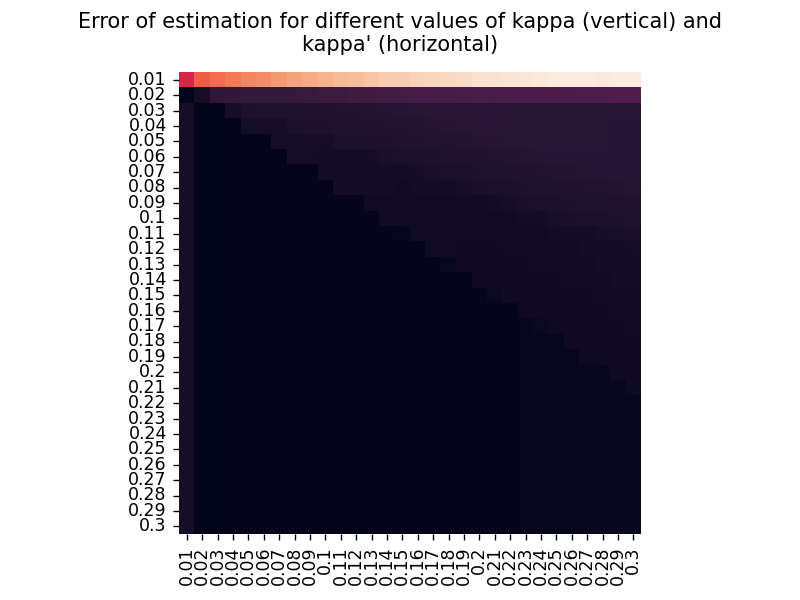

In [47]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

vmin = all_components_results_molar.min().min()
vmax = all_components_results_molar.max().max()

sns.heatmap(all_components_results_molar.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

#### Visible proportions

In [48]:
with open('results_for_different_kappas_exp7.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [49]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [50]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


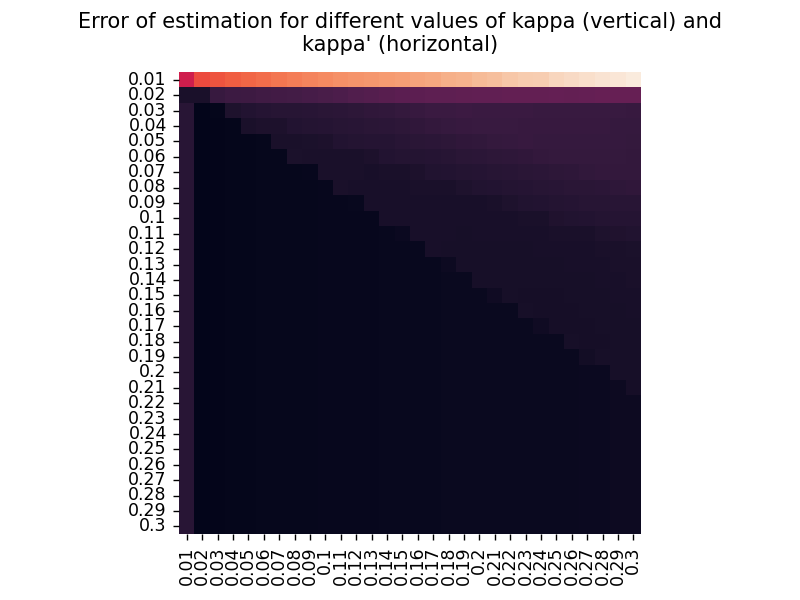

In [51]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

vmin = all_components_results_vis.min().min()
vmax = all_components_results_vis.max().max()

sns.heatmap(all_components_results_vis.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

#### Both

In [52]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [53]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [54]:
all_components_results_both.min().min()

0.08314535561159168

In [55]:
all_components_results_both[0.02][0.05]

0.08314535561159168

### Estimation

In [56]:
estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3, comp4], 
                                   MTD=0.05, MTD_th=0.02, verbose=False, solver=pulp.GUROBI())

Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55333.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1426728.10it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 108518 rows, 27132 columns and 306589 nonzeros
Model fingerprint: 0x23233c48
Coefficient statistics:
  Matrix range     [2e-10, 1e+00]
  Objective range  [2e-10, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [1e-04, 5e-02]
Presolve removed 34806 rows and 0 columns
Presolve time: 8.54s
Presolved: 27132 rows, 108517 columns, 306588 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 1.710e+05
 Factor NZ  : 6.410e+05 (roughly 60 MB

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.82s/it]


In [57]:
estimation['proportion_of_noise_in_theoretical']

0.027127614012000017

In [62]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.22749747499800013,
 0.15057183637400012,
 0.11728689957200009,
 0.1773559218180001,
 0.32728786723800024]

In [63]:
real_visible_proportions

[0.2143490442245629,
 0.1588821505833954,
 0.11109337872823348,
 0.1798063623789765,
 0.3358690640848317]

In [64]:
estimated_molar_proportions = [prop/prot for prop, prot in zip(estimated_visible_proportions, protons)]
estimated_molar_proportions = [mp/sum(estimated_molar_proportions) for mp in estimated_molar_proportions]
estimated_molar_proportions

[0.3184065028416952,
 0.21074102842995857,
 0.1313242233468972,
 0.19858252519006972,
 0.14094572019137933]

In [65]:
molar_proportions

[0.3022, 0.224, 0.1253, 0.2028, 0.1457]

### Visualisation of our estimation

In [68]:
p = np.array(estimated_visible_proportions).reshape(len(estimated_visible_proportions),1)

In [69]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [70]:
components_ints = [comp_int.reshape(-1, 1) for comp_int in components_ints]

In [71]:
X = np.concatenate(components_ints, axis=1)

In [72]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


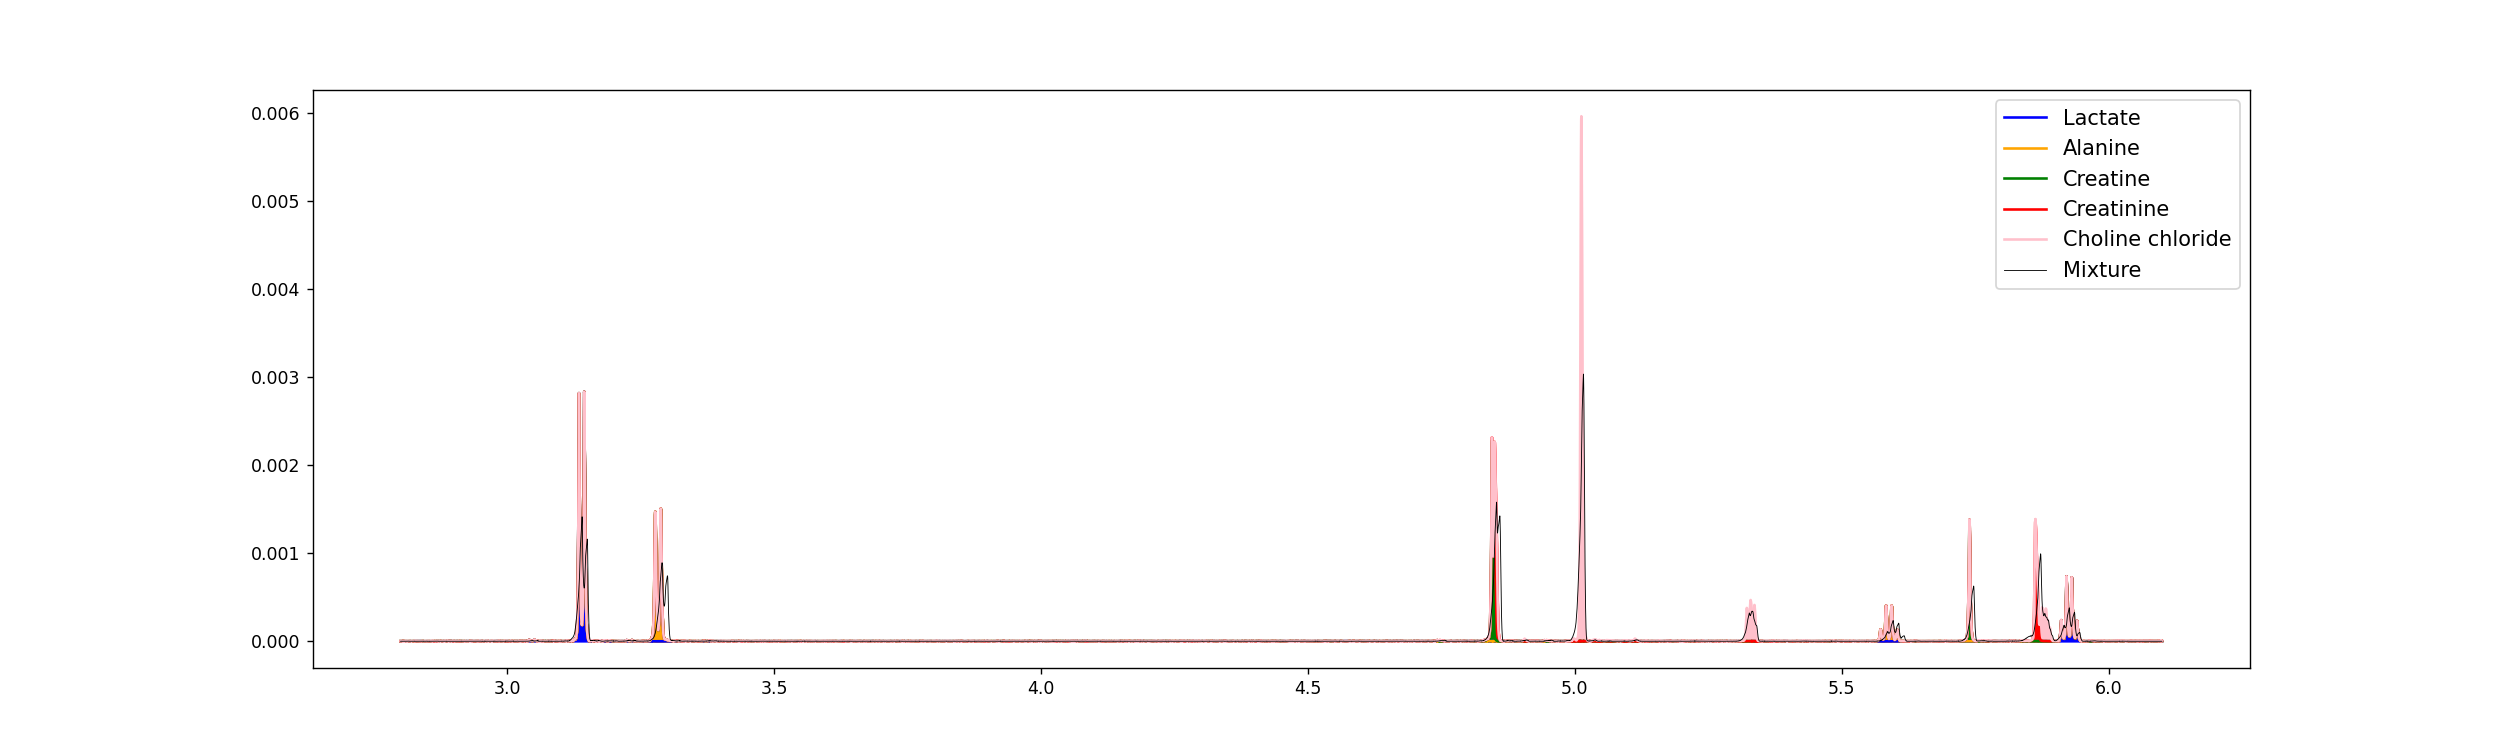

In [73]:
colors = ['blue', 'orange', 'green', 'red', 'pink']
fig, ax = plt.subplots()
fig.set_size_inches(20, 6, forward=True)
# ax.set_xlim(57,59.5)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12})